<a href="https://colab.research.google.com/github/evillag/opn/blob/main/tp3/OPN_TP3_ACFUEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet optuna
!pip install --quiet plotly

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import torch
import random

from mpl_toolkits.mplot3d import Axes3D

optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings("ignore", module="matplotlib")

_REGENERATE = False

# Trabajo práctico 3: Optimización
**Profesor Ph. D. Saúl Calderón Ramírez**

**Instituto Tecnológico de Costa Rica**

**Escuela de Computación, programa en Ciencias de Datos**

**Curso: Optimización y Programación Numérica**

---

**Fecha de entrega:** 1 de Junio de 2025.

**Entrega**: digital, por medio de la plataforma TEC-digital.

**Modo de trabajo**: Grupos de 3 personas.

*Para la documentación externa de este proyecto, incluya la explicación de cada método, y al menos 2 pruebas unitarias debidamente documentadas por cada uno. Para la documentación interna utilice un estándar de Doxygen https://tinyurl.com/55hxcd7r. La documentación externa debe realizarse en un documento pdf generado por latex, y la implementación debe entregarse en un notebook de jupyter. *


---
**Elaborado por**:

*   Andres Chavarria Sibaja
*   Fernando Ugalde Green
*   Esteban Villalobos Gomez
---

# Optimización de funciones

Para las siguientes funciones:

$$
f_{0}\left(x,y\right)=x^{2}+y^{2}
$$



$$
f_{1}\left(x,y\right)=-20e^\left[-0.2\sqrt{0.5\left(x^{2}+y^{2}\right)}\right]-e^\left[0.5\left(\cos2\pi x+\cos2\pi y\right)\right]+e+20
$$



$$
f_{2}\left(x,y\right)=(x^{2}+y-11)^{2}+(x+y^{2}-7)^{2}
$$

Con $x_{1},x_{2}\in\left[-10,10\right]$.


---


Para todos los algoritmos, ejecútelos por $P=25$ iteraciones e inicialice
las soluciones en el rango $x_{1},x_{2}\in\left[-10,10\right]$.

##  * 1.**(20 puntos)** Según tales gráficas, grafique las funciones usando la función *meshgrid* y *contour*, y distinga si las funciones son convexas o no, y los puntos mínimos y regiones o puntos silla.

In [3]:
# Versión numpy de las funciones e implementacion de graficas

def f0(x, y):
  """! @brief Función esfera.

  La función está definida como $f_0(x,y) = x^2 + y^2$.

  @param x La coordenada x (escalar o array de numpy).
  @param y La coordenada y (escalar o array de numpy).

  @return El valor de la función $f_0(x,y)$.
  """

  return x**2 + y**2

def f1(x, y):
  """! @brief Calcula la función de Ackley.
  La función está definida como $f_1(x,y) = -20e^{-0.2\sqrt{0.5(x^2+y^2)}} - e^{0.5(\cos2\pi x + \cos2\pi y)} + e + 20$.

  @param x La coordenada x (escalar o array de numpy).
  @param y La coordenada y (escalar o array de numpy).

  @return El valor de la función $f_1(x,y)$.
  """
  return -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.e + 20

def f2(x, y):
  """! @brief Calcula la función de Himmelblau.
  La función está definida como $f_2(x,y) = (x^2+y-11)^2 + (x+y^2-7)^2$.

  @param x La coordenada x (escalar o array de numpy).
  @param y La coordenada y (escalar o array de numpy).

  @return El valor de la función $f_2(x,y)$.
  """
  return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

funcs_labels = [
  (f0, "$f_0(x,y) = x^2 + y^2$"),
  (f1, "$f_1(x,y) = -20e^{-0.2\sqrt{0.5(x^2+y^2)}} - e^{0.5(\cos2\pi x + \cos2\pi y)} + e + 20$"),
  (f2, "$f_2(x,y) = (x^2+y-11)^2 + (x+y^2-7)^2$")
]

def plot_function(func, label, range_x= np.linspace(-10, 10, 100), range_y=np.linspace(-10, 10, 100),
                  mark_points=None, points_label="Mínimo"):
  """! @brief Genera y muestra un gráfico de superficie 3D (meshgrid) y un gráfico de contorno 2D para una función dada.

  Esta función toma una función matemática, su etiqueta LaTeX, rangos para x e y, y opcionalmente
  una lista de puntos para marcar en los gráficos.

  @param func La función a graficar. Debe ser un callable que acepte dos argumentos (x, y) y devuelva un valor.
  @param label Una cadena de texto (preferiblemente en formato LaTeX) que describe la función, usada en los títulos.
  @param range_x Un array de numpy que define los valores para el eje x. Por defecto, `np.linspace(-10, 10, 100)`.
  @param range_y Un array de numpy que define los valores para el eje y. Por defecto, `np.linspace(-10, 10, 100)`.
  @param mark_points Una lista opcional de tuplas `(x,y)` que representan puntos a destacar en los gráficos (e.g., mínimos, máximos, puntos silla). Por defecto, `None`.
  @param points_label Una cadena de texto para la leyenda de los puntos marcados. Por defecto, "Mínimo".

  @return None. La función muestra los gráficos directamente usando `plt.show()`.
  """
  X, Y = np.meshgrid(range_x, range_y)
  Z = func(X, Y)
  px = []
  py = []
  pz = []

  if mark_points: # Solo si hay puntos definidos para esta función
    px = np.array([p[0] for p in mark_points])
    py = np.array([p[1] for p in mark_points])
    pz = func(px, py)

  # Meshgrid
  fig = plt.figure(figsize=(14, 6))

  ax1 = fig.add_subplot(121, projection='3d')
  surf = ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.set_zlabel('$f(x,y)$')
  ax1.set_title(f'Meshgrid\n{label}')
  fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax1, label='f(x,y)')

  # Agregar puntos
  if mark_points:
      ax1.scatter(px, py, pz, color='red', marker='x', s=25, depthshade=True, label=points_label) # s es el tamaño del marcador
      # Etiqueta para cada punto
      for j in range(len(px)):
          ax1.text(px[j], py[j], pz[j] + 0.1 * np.max(Z - np.min(Z)), f'({px[j]:.1f},{py[j]:.1f})', color='red', fontsize=8)

  # Countour
  ax2 = fig.add_subplot(122)
  contour = ax2.contourf(X, Y, Z, 20, cmap='viridis') # Relleno entre contornos
  contour_lines = ax2.contour(X, Y, Z, 20, colors='black', linewidths=0.5) # Líneas de contorno
  ax2.clabel(contour_lines, inline=True, fontsize=8)
  ax2.set_xlabel('x')
  ax2.set_ylabel('y')
  ax2.set_title(f'Contour\n{label}')
  fig.colorbar(contour, ax=ax2, label='$f(x,y)$')
  # Agregar los puntos a la gráfica de contorno
  if mark_points:
    ax2.scatter(px, py, color='red', marker='x', s=25, label=points_label) # Usar scatter para consistencia
    # Añadir etiquetas a los puntos en el gráfico de contorno
    for j in range(len(px)):
        ax2.text(px[j] + 0.1, py[j] + 0.1, f'({px[j]:.1f},{py[j]:.1f})', color='red', fontsize=8)


  # Agregar leyenda si se marcaron puntos
  if mark_points:
      handles, labels = [], []
      # Obtener handles y labels de ax1 y ax2, asegurando no duplicar "Puntos Marcados"
      h1, l1 = ax1.get_legend_handles_labels()
      h2, l2 = ax2.get_legend_handles_labels()

      if h1: # Si hay leyenda en el 3D (debería haber si hay puntos)
        handles.append(h1[0]) # Asumimos que el scatter es el primer elemento con leyenda
        labels.append(l1[0])

      # Podríamos querer una sola leyenda para toda la figura
      # fig.legend(handles, labels, loc='upper center', ncol=len(labels))
      # O leyendas individuales
      ax1.legend(loc='upper right')
      ax2.legend(loc='upper right')
  plt.tight_layout()
  plt.show()

---

$f_{0}\left(x,y\right)=x^{2}+y^{2}$, con $x_{1},x_{2}\in\left[-10,10\right]$.



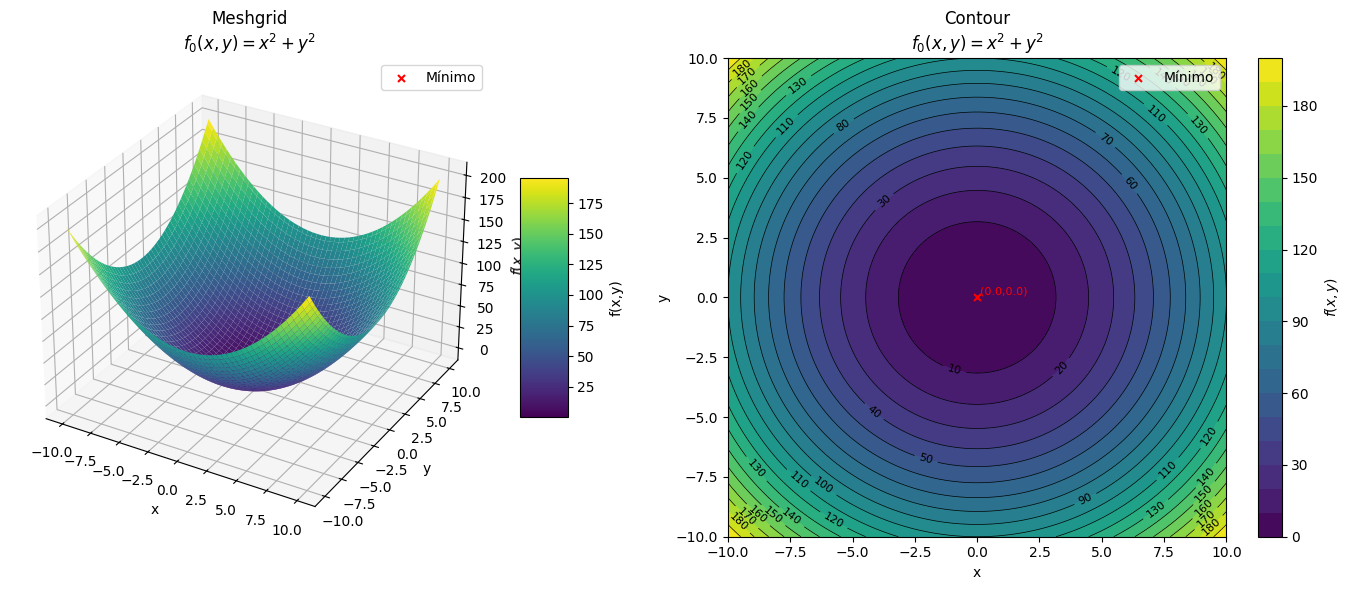

Valor en el minimo: 0


In [4]:
_f, _label = funcs_labels[0]
plot_function(_f, _label, mark_points=[(0,0)])

print("Valor en el minimo:", _f(0,0))



---


$$f_{1}\left(x,y\right)=-20e^\left[-0.2\sqrt{0.5\left(x^{2}+y^{2}\right)}\right]-e^\left[0.5\left(\cos2\pi x+\cos2\pi y\right)\right]+e+20$$

Con $x_{1},x_{2}\in\left[-10,10\right]$.

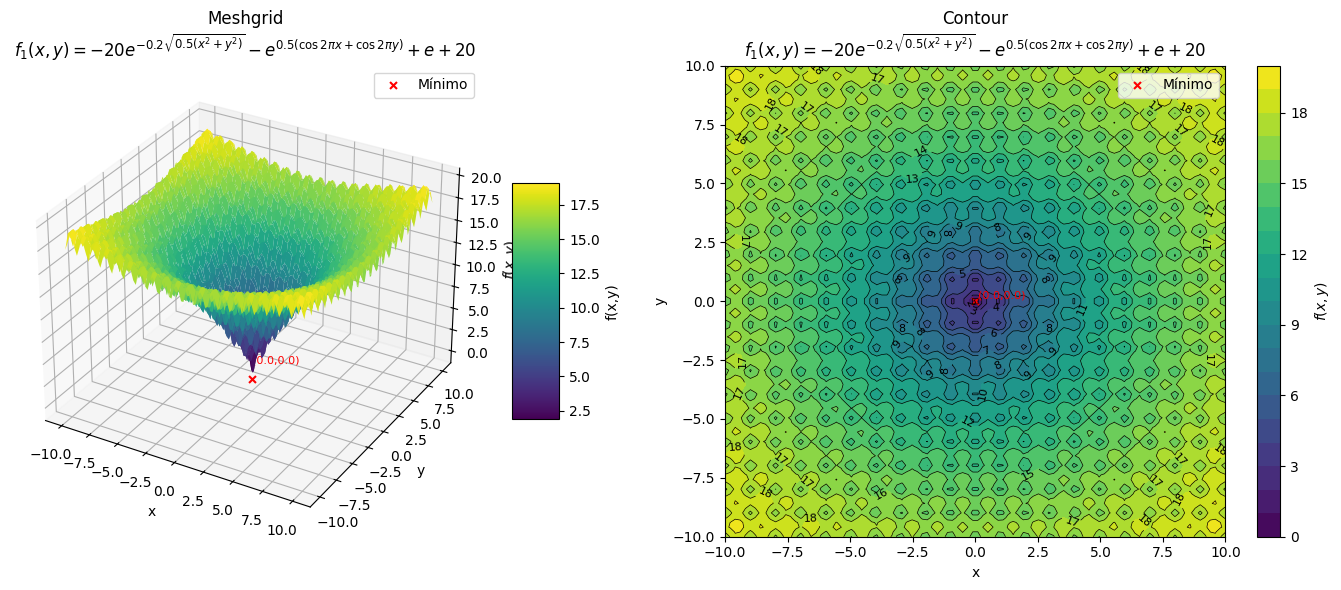

Valor en el minimo: 0.0


In [5]:
_f, _label = funcs_labels[1]
plot_function(_f, _label, mark_points=[(0,0)])

print("Valor en el minimo:", _f(0,0))

$$f_{1}\left(x,y\right)=-20e^\left[-0.2\sqrt{0.5\left(x^{2}+y^{2}\right)}\right]-e^\left[0.5\left(\cos2\pi x+\cos2\pi y\right)\right]+e+20$$

Con $x_{1},x_{2}\in\left[-5,5\right]$, haciendo un *zoom*.

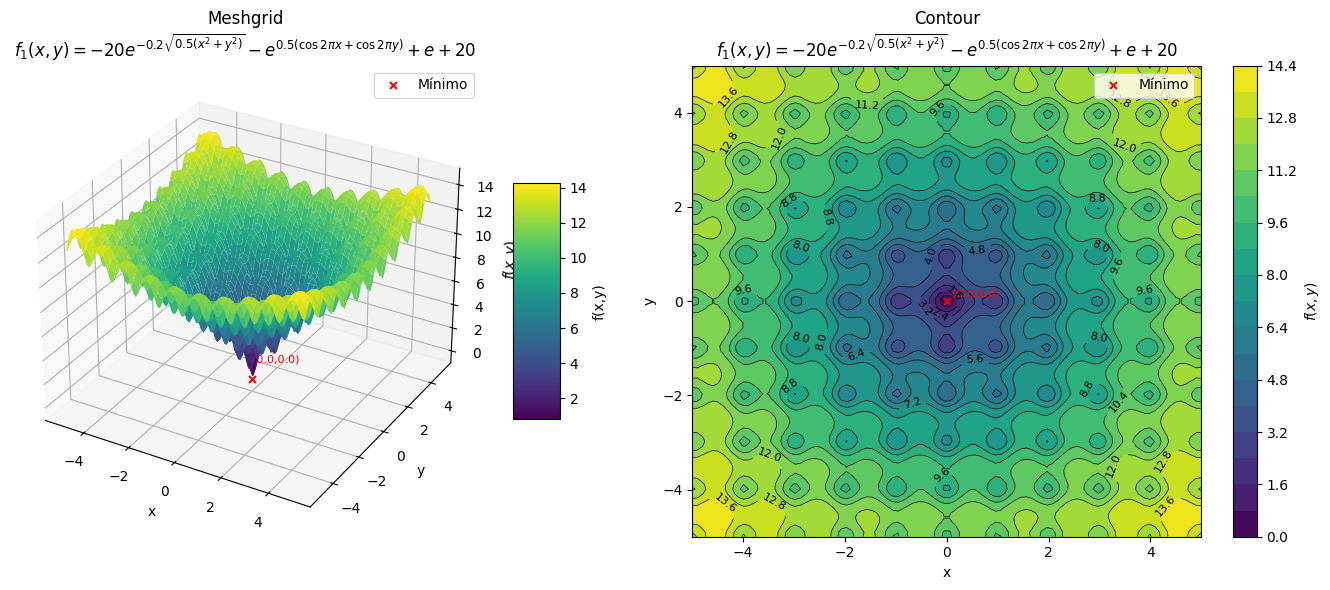

In [6]:
_f, _label = funcs_labels[1]
plot_function(_f, _label, np.linspace(-5, 5, 100), np.linspace(-5, 5, 100), mark_points=[(0,0)])



---

$$
f_{2}\left(x,y\right)=(x^{2}+y-11)^{2}+(x+y^{2}-7)^{2}
$$

Con $x_{1},x_{2}\in\left[-10,10\right]$.




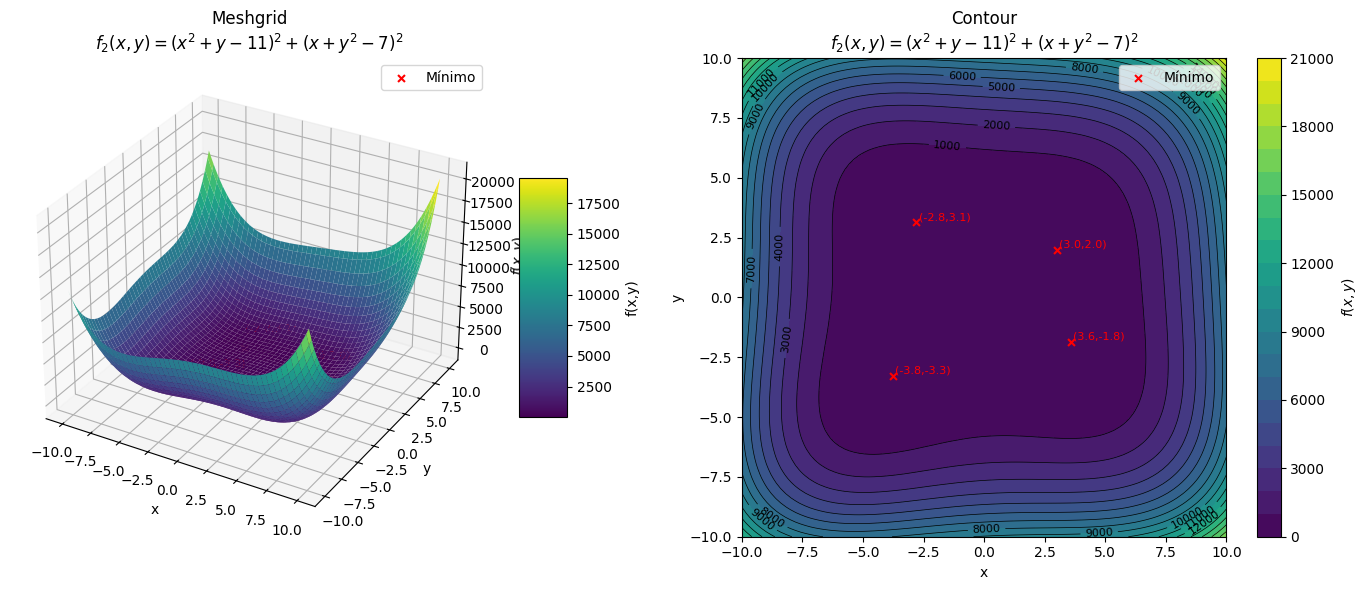

Valor en el minimo: (3,2) -> 0
Valor en el minimo: (-2.805118,3.131312) -> 1.0989296656869089e-11
Valor en el minimo: (-3.77931,-3.283186) -> 3.797861082863832e-12
Valor en el minimo: (3.584428,-1.848126) -> 8.894376497582423e-12


In [7]:
f2_minimos = [(3,2), (-2.805118, 3.131312), (-3.779310, -3.283186), (3.584428, -1.848126),]
_f, _label = funcs_labels[2]
plot_function(_f, _label, mark_points=f2_minimos)

for _x, _y in f2_minimos:
  print(f"Valor en el minimo: ({_x},{_y}) ->", _f(_x, _y))


$$
f_{2}\left(x,y\right)=(x^{2}+y-11)^{2}+(x+y^{2}-7)^{2}
$$

Con $x_{1},x_{2}\in\left[-5,5\right]$, como haciendo *zoom*.




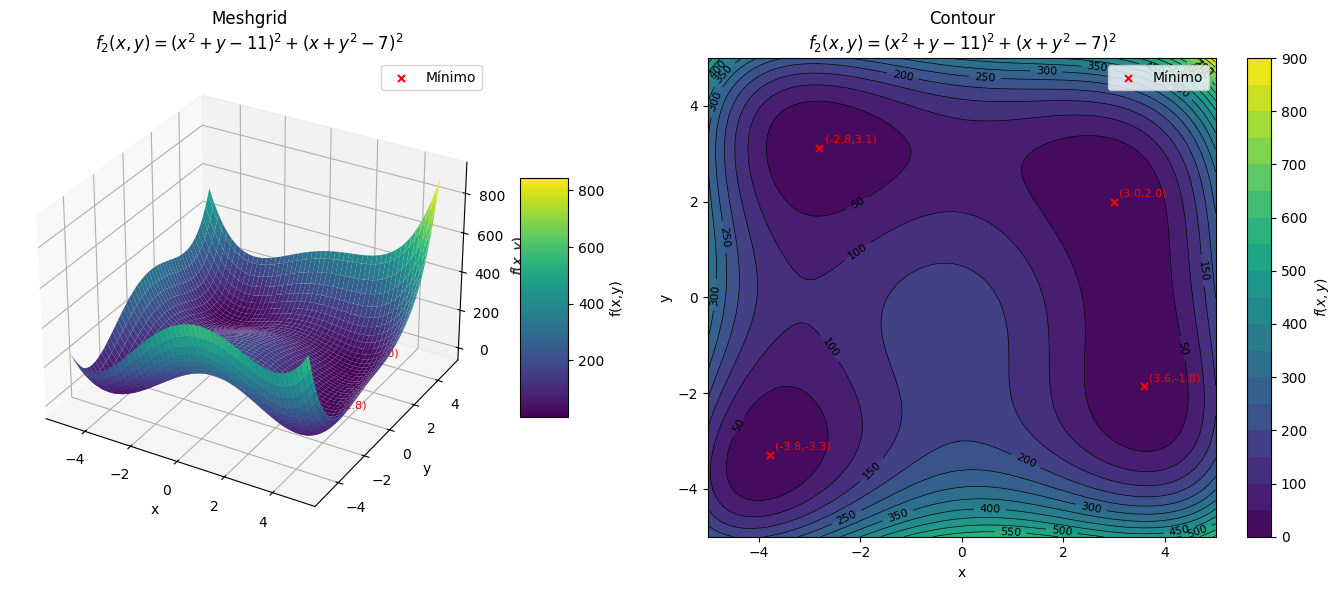

In [8]:
_f, _label = funcs_labels[2]
plot_function(_f, _label, np.linspace(-5, 5, 100), np.linspace(-5, 5, 100), mark_points=f2_minimos)



---

### Análisis de las funciones

La función $f_{0}\left(x,y\right)=x^{2}+y^{2}$, es una función **convexa**, con un único mínimo global en el punto $(0,0)$, no presenta puntos sillas



1.   La función $f_{0}\left(x,y\right)=x^{2}+y^{2}$, es una función **convexa**, con un único mínimo global en el punto $(0,0)$, no presenta ni regiones ni puntos silla.
2.   La función $f_{1}\left(x,y\right)=-20e^\left[-0.2\sqrt{0.5\left(x^{2}+y^{2}\right)}\right]-e^\left[0.5\left(\cos2\pi x+\cos2\pi y\right)\right]+e+20$, es conocida como la función de Ackley$^1$, tiene un único mínimo global en el punto $(0,0)$, pero hipotetizamos que tiene infinito número de mínimos locales, es una función **No Convexa**, y presenta múltiples puntos silla en las regiones entre mínimos locales y el mínimo global, donde la gradiente es $0$ sin estar en un mínimo.
3.   La función $f_{2}\left(x,y\right)=(x^{2}+y-11)^{2}+(x+y^{2}-7)^{2}$ es conocida como la función de Himmelblau$^2$, presenta $4$ mínimos idénticos, los cuales son los mínimos globales en $(3,2), (-2.805, 3.131), (-3.779, -3.283)$ y $(3.584, -1.848)$, es una función **No Convexa**, presenta $4$ mínimos locales que a su vez son los globales. Existe una región donde se puede considerar existen varios puntos silla, es **alrededor** de $(0,-1)$ donde la gradiente parece ser $0$ y no es un punto mínimo:

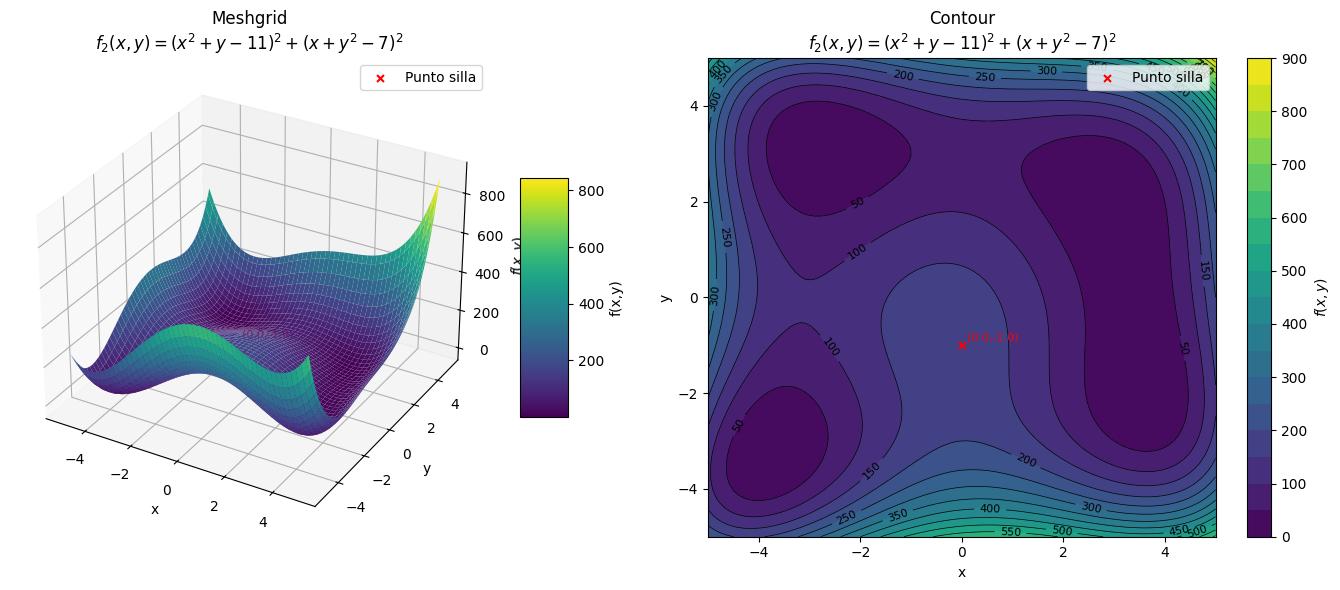

In [9]:
_f, _label = funcs_labels[2]
plot_function(_f, _label, np.linspace(-5, 5, 100), np.linspace(-5, 5, 100), mark_points=[(0,-1)], points_label="Punto silla")

Notas:


*   $^1$ Ackley, D. H. (1987). The model. In A Connectionist Machine for Genetic Hillclimbing (pp. 29-70). Boston, MA: Springer US.
*   $^2$ Himmelblau, D. M. (2018). Applied nonlinear programming. McGraw-Hill.

---



## * 2.(40 puntos) Implemente el algoritmo del **RMS prop**. para encontrar el punto mínimo en pytorch, de la forma mas vectorial posible. Implemente las siguientes pruebas.

*   a) Para cada función, calibre los hiper-parámetros del algoritmo, mostrando el proceso de calibrado usando las gráficas de aprendizaje, y reporte los mejores valores encontrados.
      *    1) Realice el proceso de calibración usando un framework como optuna https://optuna.org/ o weights and biases https://wandb.ai/site. Reporte los mejores valores encontrados.

*    b) Realice lo anterior para el algoritmo del descenso del gradiente.
*    c) ¿Porqué el algoritmo RMS prop es más efectivo en evitar atascarse en puntos silla que el algoritmo del descenso del gradiente?
*    d) Para los mejores valores encontrados, en cada funcion, por un máximo de 50 iteraciones (para el algoritmo del descenso del gradiente, y RMS prop):
      *    1) Ejecute el algoritmo 10 corridas diferentes, y documente en una tabla la cantidad de iteraciones para converger a el o los puntos minimos (indique si convergió).
      *    2) Muestre el valor promedio de la función minimizada para las 10 corridas, y la cantidad de iteraciones promedio en converger.
*    e) Muestre los puntos visitados del algoritmo para la mejor corrida (convergencia mas rapida) para cada función. Para ello use el gráfico de las curvas de nivel. Además para tales corridas, grafique la curva de aprendizaje.
*    f ) Realice una comparativa entre el algoritmo del descenso del gradiente y el algoritmo RMS prop. según los resultados obtenidos.

#### Redefinicion de funciónes a optimizar utilizando PyTorch




In [10]:
### f0 ###
def f0_pytorch(x):
  """!
  @brief Calcula la función Esfera usando PyTorch.
  La función está definida como $f_0(x,y) = x^2 + y^2$.

  @param x Tensor de PyTorch de [2,n] dimensiones, cada fila representa un punto (x,y).

  @return Tensor de PyTorch con el resultado de la función $f_0$.
  """
  return torch.sum(x**2, dim=1)

### f1 ###
def f1_pytorch(x):
  """!
  @brief Calcula la función de Ackley usando PyTorch.
  $f_1(x,y) = -20 \exp(-0.2 \sqrt{0.5(x^2+y^2)}) - \exp(0.5(\cos(2\pi x) + \cos(2\pi y))) + e + 20$.

  @param x Tensor de PyTorch de [2,n] dimensiones, cada fila representa un punto (x,y).

  @return Tensor de PyTorch con el valor de la función $f_1$.
  """
  term1 = -20.0 * torch.exp(-0.2 * torch.sqrt(0.5 * torch.sum(x**2, dim=1)))
  term2 = -torch.exp(0.5 * (torch.cos(2 * torch.pi * x[:, 0]) + torch.cos(2 * torch.pi * x[:,1])))
  return term1 + term2 + torch.e + 20.0

### f2 ###
def f2_pytorch(x):
  """!
  @brief Calcula la función de Himmelblau usando PyTorch.

  @param x Tensor de PyTorch de [2,n] dimensiones, cada fila representa un punto (x,y).

  @return Tensor de PyTorch con el valor de la función $f_1$.
  """
  term1 = (x[:, 0]**2 + x[:, 1]    - 11.0)**2
  term2 = (x[:, 0]    + x[:, 1]**2 - 7.0)**2
  return term1 + term2

Las siguientes son los vectores gradiente de cada función:

\begin{equation*}
\nabla f_0(x,y) =
\begin{bmatrix}
2x \\
2y
\end{bmatrix}
\end{equation*}


In [11]:
def f0_dxy_pytorch(x):
  """!
  @brief Calcula el vector gradiente de de la función Esfera usando PyTorch.

  @param x Tensor de PyTorch de [2,n] dimensiones, cada fila representa un punto (x,y).

  @return Tensor de PyTorch con el vector gradiente de la función $f_0$.
  """
  return 2*x


\begin{equation*}
\nabla f_1(x,y) =
\begin{bmatrix}
\frac{2x \cdot \exp\left(-0.2\sqrt{0.5(x^2+y^2)}\right)}{\sqrt{0.5(x^2+y^2)}} + \pi \sin(2\pi x) \exp\left(0.5(\cos(2\pi x) + \cos(2\pi y))\right) \\
\\
\frac{2y \cdot \exp\left(-0.2\sqrt{0.5(x^2+y^2)}\right)}{\sqrt{0.5(x^2+y^2)}} + \pi \sin(2\pi y) \exp\left(0.5(\cos(2\pi x) + \cos(2\pi y))\right)
\end{bmatrix}
\end{equation*}


In [12]:
def f1_dxy_pytorch(x):
  """!
  @brief Calcula el vector gradiente de la función de Ackley.

  @param x Tensor de PyTorch de [2,n] dimensiones, cada fila representa un punto (x,y).

  @return Tensor de PyTorch con el vector gradiente de la función $f_1$.
  """
  epsilon = 1e-8  # Valor para evitar divisiones entre cero.

  # Componentes comunes
  sqrt_term_val = 0.5 * (x[:, 0]**2 + x[:, 1]**2)

  dfdx_term1 = 2 * x[:, 0] * torch.exp(-0.2 * torch.sqrt(sqrt_term_val)) / (torch.sqrt(sqrt_term_val) + epsilon)
  dfdx_term2 = torch.pi * torch.sin(2 * torch.pi * x[:, 0]) * torch.exp(0.5 * (torch.cos(2 * torch.pi * x[:, 0]) + torch.cos(2 * torch.pi * x[:, 1])))
  dfdx = dfdx_term1 + dfdx_term2

  dfdy_term1 = 2 * x[:, 1] * torch.exp(-0.2 * torch.sqrt(sqrt_term_val)) / (torch.sqrt(sqrt_term_val) + epsilon)
  dfdy_term2 = torch.pi * torch.sin(2 * torch.pi * x[:, 1]) * torch.exp(0.5 * (torch.cos(2 * torch.pi * x[:, 0] + torch.cos(2 * torch.pi * x[:, 1]))))
  dfdy = dfdy_term1 + dfdy_term2

  return torch.stack([dfdx, dfdy], dim=1)


\begin{equation*}
\nabla f_2(x,y) =
\begin{bmatrix}
4x^3+4xy-42x+2y^2-14  \\
2x^2 +4xy+4y^3-26y-22 \\
\end{bmatrix}
\end{equation*}


In [13]:
def f2_dxy_pytorch(x):
  """!
  @brief Calcula el vector gradiente de la función de Himmelblau usando PyTorch.

  @param x Tensor de PyTorch de [2,n] dimensiones, cada fila representa un punto (x,y).

  @return Tensor de PyTorch con el valor de la derivada de la función $f_1$.
  """
  # df/dx= 4x^3          +4xy                −42x       +2y^2         −14
  dfdx =   4*(x[:, 0]**3)+4*x[:, 0] * x[:, 1]-42*x[:, 0]+2*(x[:,1]**2)-14
  # df/dy= 2x^2          +4xy                +4y^3          −26y       −22
  dfdy =   2*(x[:, 0]**2)+4*x[:, 0] * x[:, 1]+4*(x[:, 1]**3)-26*x[:, 1]-22
  return torch.stack([dfdx, dfdy], dim=1)

##### Unit tests de funciones y derivadas en pytorch

In [14]:
## Unit Tests funciones en pytorch
print("** Unit Test de Funciones version pytorch **")

def test_funcion(no_test, x, new_function, old_function):
  expected = torch.tensor([old_function(x,y) for x, y in x.numpy()], dtype=torch.float32)
  actual = new_function(x)
  try:
    assert torch.all(torch.isclose(actual, expected))
    print(f"Test {no_test} PASSED: new_function = {actual}, old_function = {expected}")
  except AssertionError:
    print(f"Test {no_test} FAILED: new_function = {actual}, old_function = {expected}")


def test_derivada(no_test, x, func_a_derivar, derivative_func):
  """!
  @brief Hace una comparacion de la implementacion de la derivada analitica vs el Autograd de Pytorch.
  """

  loss = torch.sum(func_a_derivar(x))
  loss.backward()
  expected_grad = x.grad
  with torch.no_grad():
    actual_grad = derivative_func(x)
    try:
      assert torch.all(torch.isclose(actual_grad, expected_grad))
      print(f"Test {no_test} PASSED:\nderivative_func = {actual_grad}\nexpected_grad = {expected_grad}")
    except AssertionError:
      print(f"Test {no_test} FAILED:\nderivative_func = {actual_grad}\nexpected_grad = {expected_grad}")


a1 = torch.tensor([[1., -1.], [2., -2.]])
a2 = torch.tensor([[1., -1.]])
print("a1 = ", a1)
print("a2 = ", a2)
test_funcion(0, a1, f0_pytorch, f0)
test_funcion(1, a2, f0_pytorch, f0)
test_funcion(2, a1, f1_pytorch, f1)
test_funcion(3, a2, f1_pytorch, f1)
test_funcion(4, a1, f2_pytorch, f2)
test_funcion(5, a2, f2_pytorch, f2)
print("Derivadas")
a1 = torch.tensor([[1., -1.], [2., -2.]], requires_grad=True)
a2 = torch.tensor([[1., -1.]], requires_grad=True)
test_derivada(6, a1, f0_pytorch, f0_dxy_pytorch)
test_derivada(7, a2, f0_pytorch, f0_dxy_pytorch)
print("")
a3 = torch.tensor([[1., -1.], [2., -2.]], requires_grad=True)
a4 = torch.tensor([[1., -1.]], requires_grad=True)
test_derivada(8, a3, f1_pytorch, f1_dxy_pytorch)
print("")
test_derivada(9, a4, f1_pytorch, f1_dxy_pytorch)
print("")
a5 = torch.tensor([[1., -1.], [2., -2.]], requires_grad=True)
print("")
a6 = torch.tensor([[1., -1.]], requires_grad=True)
test_derivada(10, a5, f2_pytorch, f2_dxy_pytorch)
print("")
test_derivada(11, a6, f2_pytorch, f2_dxy_pytorch)

# Limpieza de memoria
del(a1, a2, a3, a4, a5, a6)

** Unit Test de Funciones version pytorch **
a1 =  tensor([[ 1., -1.],
        [ 2., -2.]])
a2 =  tensor([[ 1., -1.]])
Test 0 PASSED: new_function = tensor([2., 8.]), old_function = tensor([2., 8.])
Test 1 PASSED: new_function = tensor([2.]), old_function = tensor([2.])
Test 2 PASSED: new_function = tensor([3.6254, 6.5936]), old_function = tensor([3.6254, 6.5936])
Test 3 PASSED: new_function = tensor([3.6254]), old_function = tensor([3.6254])
Test 4 PASSED: new_function = tensor([146.,  82.]), old_function = tensor([146.,  82.])
Test 5 PASSED: new_function = tensor([146.]), old_function = tensor([146.])
Derivadas
Test 6 PASSED:
derivative_func = tensor([[ 2., -2.],
        [ 4., -4.]])
expected_grad = tensor([[ 2., -2.],
        [ 4., -4.]])
Test 7 PASSED:
derivative_func = tensor([[ 2., -2.]])
expected_grad = tensor([[ 2., -2.]])

Test 8 PASSED:
derivative_func = tensor([[ 1.6375, -1.6375],
        [ 1.3406, -1.3406]])
expected_grad = tensor([[ 1.6375, -1.6375],
        [ 1.3406, -1.3

#### Adaptación de función de graficación

In [15]:
funcs_pytorch_labels = [
  (f0_pytorch, f0_dxy_pytorch, "$f_0(x,y) = x^2 + y^2$"),
  (f1_pytorch, f1_dxy_pytorch, "$f_1(x,y) = -20e^{-0.2\sqrt{0.5(x^2+y^2)}} - e^{0.5(\cos2\pi x + \cos2\pi y)} + e + 20$"),
  (f2_pytorch, f2_dxy_pytorch, "$f_2(x,y) = (x^2+y-11)^2 + (x+y^2-7)^2$")
]

# Nueva funcion para plotear la ruta del optimizador y la convergencia del error
PLOT_RANGE = (-5, 5)

def plot_optimization_results(f_func, history_params, history_f_values, func_name_str="Función 2D",
                              optimizer_name_str="Optimizador", plot_range=PLOT_RANGE, mark_points=None,
                              points_label="Mínimo"):
  """!
  @brief Grafica los resultados de un proceso de optimización 2D.

  Genera dos subplots:
  1. El valor de la función f(x,y) vs. el número de iteración.
  2. Un gráfico de contorno de la función f(x,y) con la trayectoria de optimización (x,y) superpuesta.

  @param f_func La función PyTorch f(x,y) que fue optimizada.
  @param history_params Lista de tuplas (x,y) que representan la trayectoria de los parámetros.
  @param history_f_values Lista de los valores de la función f(x,y) en cada iteración.
  @param func_name_str Nombre de la función (string, puede ser LaTeX) para los títulos.
  @param optimizer_name_str Nombre del optimizador (string) para los títulos.
  @param plot_range Tupla (min_val, max_val) para los ejes x e y del gráfico de contorno.
  """

  plt.figure(figsize=(14, 6)) # Ajustado para mejor visualización de dos subplots

  # Valor de la función vs. Iteración
  plt.subplot(1, 2, 1)
  plt.plot(history_f_values, marker='o', linestyle='-', markersize=3, linewidth=1)
  plt.xlabel('Iteración')
  plt.ylabel('$f(x,y)$')
  plt.title(f'Convergencia: {func_name_str}\n({optimizer_name_str})')
  plt.grid(True)
  if history_f_values: # Añadir texto con el valor final
      plt.text(0.95, 0.05, f'Final $f(x,y) = {history_f_values[-1]:.4e}$',
               verticalalignment='bottom', horizontalalignment='right',
               transform=plt.gca().transAxes, fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))


  # Gráfico de Contorno y Trayectoria
  plt.subplot(1, 2, 2)

  # Generar datos para el contorno
  x_contour_vals = np.linspace(plot_range[0], plot_range[1], 100)
  y_contour_vals = np.linspace(plot_range[0], plot_range[1], 100)
  X_contour, Y_contour = np.meshgrid(x_contour_vals, y_contour_vals)

  # Convertir arrays de NumPy a tensores de PyTorch para la evaluación de la función
  X_torch = torch.tensor(X_contour, dtype=torch.float32)
  Y_torch = torch.tensor(Y_contour, dtype=torch.float32)

  # Evaluar la función en la malla. Suponemos que f_func_pytorch devuelve un tensor.
  # Usamos torch.no_grad() ya que no necesitamos calcular gradientes para el plot.
  with torch.no_grad():
      Z_contour = f_func(torch.stack([X_torch, Y_torch], dim=1)).numpy() # Convertir de vuelta a NumPy para matplotlib

  # Dibujar el contorno
  contour = plt.contourf(X_contour, Y_contour, Z_contour, 20, cmap='viridis', alpha=0.75)
  contour_lines = plt.contour(X_contour, Y_contour, Z_contour, 20, colors='black', linewidths=0.5, alpha=0.5)
  plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.1f')
  plt.colorbar(contour, label='$f(x,y)$')

  # Extraer ruta
  if history_params:
      history_x_coords = [p[0] for p in history_params]
      history_y_coords = [p[1] for p in history_params]

      plt.plot(history_x_coords, history_y_coords, marker='.', linestyle='-', color='white', markersize=3, linewidth=1,
               label=f'Trayectoria ({optimizer_name_str})', alpha=0.9)
      plt.scatter(history_x_coords[0], history_y_coords[0], color='lime', s=50, edgecolor='black', label='Inicio', zorder=5)
      plt.scatter(history_x_coords[-1], history_y_coords[-1], color='red', s=50, edgecolor='black', label='Fin', zorder=5)

  plt.xlabel('x')
  plt.ylabel('y')
  plt.title(f'Ruta de Optimización: {func_name_str}\n({optimizer_name_str}) en [{plot_range[0]},{plot_range[1]}]')
  plt.legend(fontsize='small')
  plt.axis('equal')
  plt.xlim(plot_range[0], plot_range[1])
  plt.ylim(plot_range[0], plot_range[1])
  plt.grid(True, linestyle='--', alpha=0.5)

  # Agregar los puntos a la gráfica de contorno
  if mark_points:
    px = np.array([torch.tensor(p[0], dtype=torch.float32) for p in mark_points])
    py = np.array([torch.tensor(p[1], dtype=torch.float32) for p in mark_points])
    plt.scatter(px, py, color='yellow', marker='x', s=25, label=points_label) # Usar scatter para consistencia
    # Añadir etiquetas a los puntos en el gráfico de contorno
    for j in range(len(px)):
        plt.text(px[j] + 0.1, py[j] + 0.1, f'({px[j]:.1f},{py[j]:.1f})', color='yellow', fontsize=8)


  # Agregar leyenda si se marcaron puntos
  if mark_points:
      plt.legend(loc='upper right')
      plt.legend(loc='upper right')

  plt.tight_layout()
  plt.show()

### Implementación de RMSProp

In [16]:
def rmsprop(func_to_optimize, derivative_func, initial_params, learning_rate=0.1, gamma=0.9, N=100, epsilon=1e-8,
            history_params_x=[], history_fx=[], verbose=False):
  """!
  @brief Implementa el algoritmo Adagrad usando PyTorch para optimizar una función de dos variables f(x,y),
         aceptando hiperparámetros y opciones de control vía kwargs.

  @param func_to_optimize (callable): La función a optimizar. Debe tomar un tensor de PyTorch (x, y) y devolver un tensor.
  @param derivative_func (callable): La derivada de la función a optimizar. Debe tomar dos tensores de PyTorch (x, y) y devolver dos tensores.
  @param initial_params (tensor, opcional): Tensor [[x_init, y_init]] con los valores iniciales.
                                            Por defecto: [[-8.0, -8.0]].
  @param learning_rate (float, opcional): Learning rate global (rho o lr).
                                          Por defecto: 0.1.
  @param gamma (float, opcional): Factor de decaimiento para la media móvil de los gradientes cuadrados.
                                  Por defecto: 0.9.
  @param N (int, opcional): Número de iteraciones.
                            Por defecto: 100.
  @param epsilon (float, opcional): Pequeño valor para evitar la división por cero.
                                    Por defecto: 1e-8.
  @param history_params_x (list, opcional): Lista de tuplas (x,y) que representan la trayectoria de los parámetros.
                                            Por defecto: [].
  @param history_fx (list, opcional): Lista de los valores de la función f(x,y) en cada iteración.
                                      Por defecto: [].
  @param verbose (bool, opcional): Si True, imprime información durante la ejecución. Por defecto: False.

  @return Float: Valor final de f(x,y).
  """

  params_t = initial_params.clone()
  mean_squared_gradients = torch.zeros_like(params_t)  # Valor historico de S_i
  current_f_val = torch.sum(func_to_optimize(params_t)).item()

  history_params_x.append((params_t[:, 0].item(), params_t[:, 1].item()))
  history_fx.append(current_f_val)

  if verbose:
    print(f"Initial: params_t = ({params_t}), f(params_t) = {current_f_val:.4f}")

  for i in range(N):
    grad = derivative_func(params_t)
    mean_squared_gradients = gamma * mean_squared_gradients + (1 - gamma) * (grad**2)

    update_val = (learning_rate / (torch.sqrt(mean_squared_gradients) + epsilon)) * grad
    params_t -= update_val

    x_updated, y_updated = params_t[:, 0], params_t[:, 1]
    updated_f_val = torch.sum(func_to_optimize(params_t)).item() # Asegurarse de usar el valor actualizado

    history_params_x.append((x_updated.item(), y_updated.item()))
    history_fx.append(updated_f_val)

    if verbose:
      if (i + 1) % (N // 10 if N >= 10 else 1) == 0 or N < 10 : # Imprimir con menos frecuencia para N grandes
        print(f"Iter {i+1}/{N}: f({x_updated.item()},\t{y_updated.item()})\t=\t{updated_f_val},\tgrad=[{grad}]")

    if np.abs(current_f_val - updated_f_val) < epsilon:
      if verbose:
        print(f"\n*** Iter {i+1}: CONVERGIO! en f({x_updated.item()},\t{y_updated.item()})\t=\t{updated_f_val}...\n")
      break
    current_f_val = updated_f_val

  return current_f_val


history_params_test = []
# Smoke test
last_value = rmsprop(**{
  'func_to_optimize': lambda x: x**2,
  'derivative_func': lambda x: 2*x,
  'initial_params': torch.tensor([[-10.0, -10.0]], requires_grad=False),
  'learning_rate': 1.0,
  'gamma': 0.9,
  'N': 100,
  'epsilon': 1e-8,
  'history_params_x': history_params_test,
  'history_fx': [],
  'verbose': True
})

print("f(x,y):", last_value, "| (x,y): ", history_params_test[-1], "| iteraciones:", len(history_params_test)-1)
del(history_params_test)

Initial: params_t = (tensor([[-10., -10.]])), f(params_t) = 200.0000
Iter 10/100: f(-0.3211708664894104,	-0.3211708664894104)	=	0.20630145072937012,	grad=[tensor([[-0.9687, -0.9687]])]
Iter 20/100: f(-0.0006863485323265195,	-0.0006863485323265195)	=	9.421486311111948e-07,	grad=[tensor([[-0.0032, -0.0032]])]

*** Iter 24: CONVERGIO! en f(-9.902934834826738e-06,	-9.902934834826738e-06)	=	1.9613623225556154e-10...

f(x,y): 2.2328465743015613e-09 | (x,y):  (-9.902934834826738e-06, -9.902934834826738e-06) | iteraciones: 24


#### Unit tests de `rmsprop`

In [17]:
P = 100

def test(test_name="", optimizer=rmsprop, **test_settings):
  optimizer_params = test_settings['optimizer_params']
  test_tolerance = test_settings['test_tolerance']

  f_x = optimizer(**optimizer_params)
  x, y = optimizer_params['history_params_x'][-1]

  if test_settings.get('plot', None):
    plot_settings = test_settings['plot']
    plot_optimization_results(
      optimizer_params['func_to_optimize'],
      optimizer_params['history_params_x'],
      optimizer_params['history_fx'],
      func_name_str=plot_settings['func_name_str'],
      optimizer_name_str=plot_settings["optimizer_name_str"],
      plot_range=plot_settings.get('plot_range', PLOT_RANGE),
      mark_points=plot_settings.get('mark_points', None),
      points_label=plot_settings.get("points_label", "Mínimo"),
    )

  print(f"\nLast point (x, y):\t({x:0.3f}, {y:0.3f})")
  one_passed = False
  for expected_x_y in test_settings['expected_x_y']:
    expected_x, expected_y = expected_x_y
    one_passed = abs(x-expected_x) <= test_tolerance and abs(y-expected_y) <= test_tolerance
    print(f"Expected point (x, y):\t({expected_x:0.3f}, {expected_y:0.3f})")
    if one_passed:
      break
  try:
    assert(one_passed)
    print(f"\n** {test_name}: PASSED!")
  except AssertionError:
    print(f"\n** {test_name}: FAILED!")


Initial: params_t = (tensor([[-3.,  4.]])), f(params_t) = 25.0000
Iter 10/100: f(-0.003309684805572033,	0.097845159471035)	=	0.009584629908204079,	grad=[tensor([[-0.0234,  0.3477]])]

*** Iter 17: CONVERGIO! en f(1.2093077650376927e-09,	4.573819751385599e-06)	=	2.0919828369603266e-11...



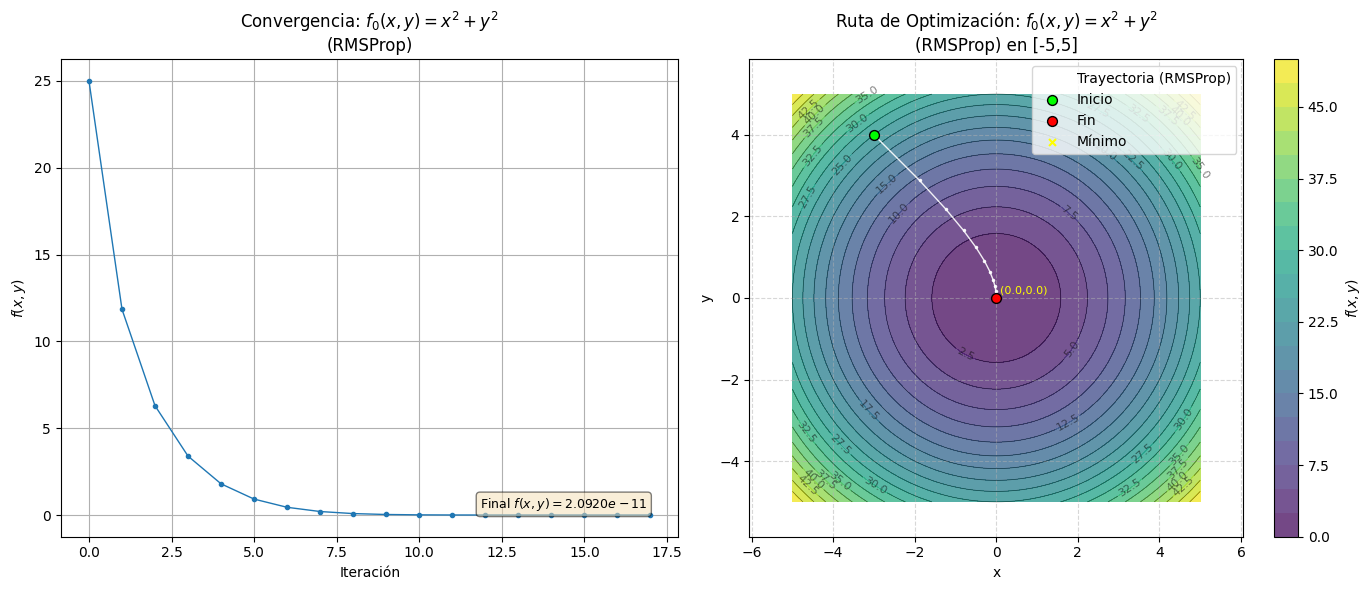


Last point (x, y):	(0.000, 0.000)
Expected point (x, y):	(0.000, 0.000)

** test_1: PASSED!


In [18]:
# Para f0, prueba desde (-3, 4), mínimo global: (0,0)
test_1_settings = {
  'optimizer_params': {
    'func_to_optimize': funcs_pytorch_labels[0][0],
    'derivative_func': funcs_pytorch_labels[0][1],
    'initial_params': torch.tensor([[-3.0, 4.0]], requires_grad=False),
    'learning_rate': 0.5,
    'N': P,
    'gamma': 0.8,
    'epsilon': 1e-8,
    'history_params_x': [],
    'history_fx': [],
    'verbose': True
  },
  'expected_x_y': [(0.0, 0.0)],
  'test_tolerance': 1e-2,
  'plot': {
    'func_name_str':funcs_pytorch_labels[0][2],
    'optimizer_name_str': "RMSProp",
    'plot_range': (-5, 5),
    'mark_points': [(0, 0)],
    'points_label': 'Mínimo',
  }
}

test("test_1", **test_1_settings)

Initial: params_t = (tensor([[-3.,  4.]])), f(params_t) = 10.1386
Iter 10/100: f(-0.01625192165374756,	-0.2631913423538208)	=	1.8726310729980469,	grad=[tensor([[2.4242, 2.1378]])]
Iter 20/100: f(-0.15500256419181824,	1.0784211158752441)	=	3.5165634155273438,	grad=[tensor([[ 1.4147, -2.2055]])]
Iter 30/100: f(-0.005982398986816406,	-0.06276743859052658)	=	0.28082275390625,	grad=[tensor([[-4.5563,  1.2190]])]
Iter 40/100: f(0.3191274404525757,	-0.15789739787578583)	=	2.635326385498047,	grad=[tensor([[-5.4774,  3.1868]])]
Iter 50/100: f(-0.052115947008132935,	-0.05061782896518707)	=	0.34125518798828125,	grad=[tensor([[5.9140, 3.6743]])]
Iter 60/100: f(-0.10733464360237122,	-0.06635002791881561)	=	0.7377166748046875,	grad=[tensor([[7.0353, 3.5038]])]
Iter 70/100: f(-0.0951336920261383,	-0.10541537404060364)	=	0.8734245300292969,	grad=[tensor([[6.0548, 5.1138]])]
Iter 80/100: f(-0.10682092607021332,	-0.07767653465270996)	=	0.7877883911132812,	grad=[tensor([[6.5834, 4.3081]])]
Iter 90/100: f

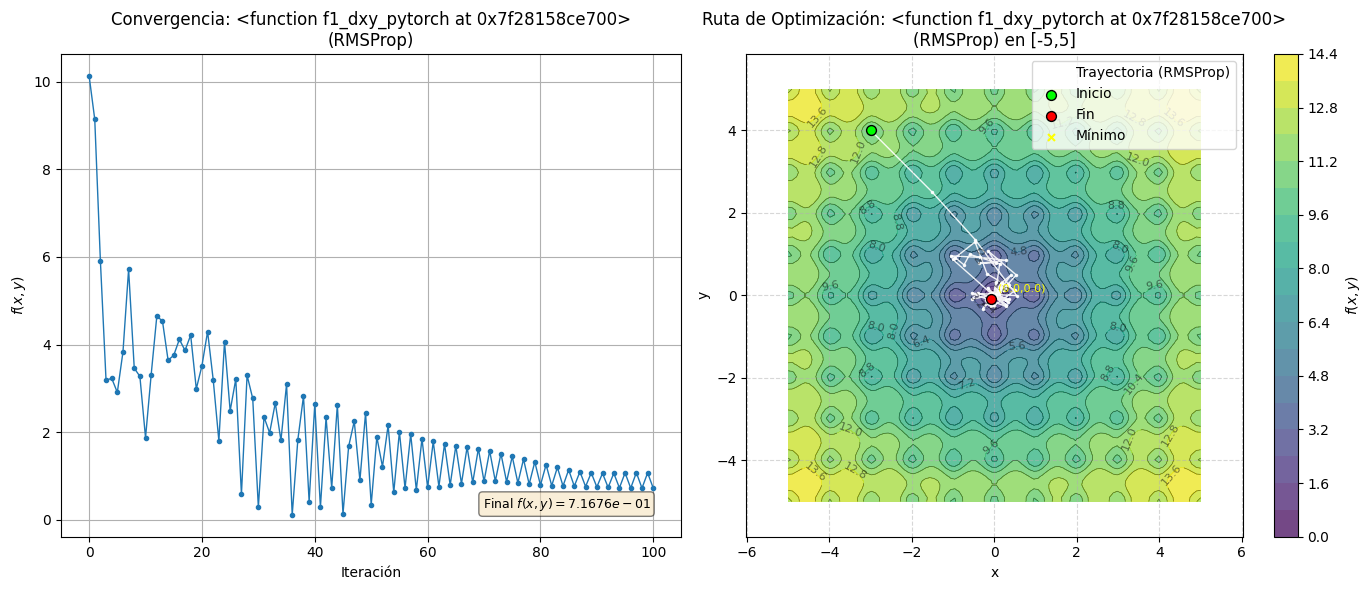


Last point (x, y):	(-0.079, -0.095)
Expected point (x, y):	(-0.079, -0.095)

** test_2: PASSED!


In [19]:
# Ackley (f1), prueba desde (-3, 4), mínimo global: (0,0)
test_2_settings = {
  'optimizer_params': {
    'func_to_optimize': funcs_pytorch_labels[1][0],
    'derivative_func': funcs_pytorch_labels[1][1],
    'initial_params': torch.tensor([[-3.0, 4.0]], requires_grad=False),
    'learning_rate': 0.15,
    'N': P,
    'gamma': 0.99,
    'epsilon': 1e-3,
    'history_params_x': [],
    'history_fx': [],
    'verbose': True
  },
  'expected_x_y': [(-0.079, -0.095)],
  'test_tolerance': 1e-2,
  'plot': {
    'func_name_str':funcs_pytorch_labels[1][1],
    'optimizer_name_str': "RMSProp",
    'plot_range': (-5, 5),
    'mark_points': [(0, 0)],
    'points_label': 'Mínimo',
  }
}

test("test_2", **test_2_settings)

Initial: params_t = (tensor([[ 0., -1.]])), f(params_t) = 180.0000
Iter 10/100: f(2.829317092895508,	1.8397281169891357)	=	1.9524976015090942,	grad=[tensor([[-23.8281, -13.4575]])]
Iter 20/100: f(2.9998581409454346,	2.00020432472229)	=	8.739771146792918e-07,	grad=[tensor([[-0.0181,  0.0116]])]

*** Iter 23: CONVERGIO! en f(2.9999990463256836,	2.0000009536743164)	=	3.092281986027956e-11...



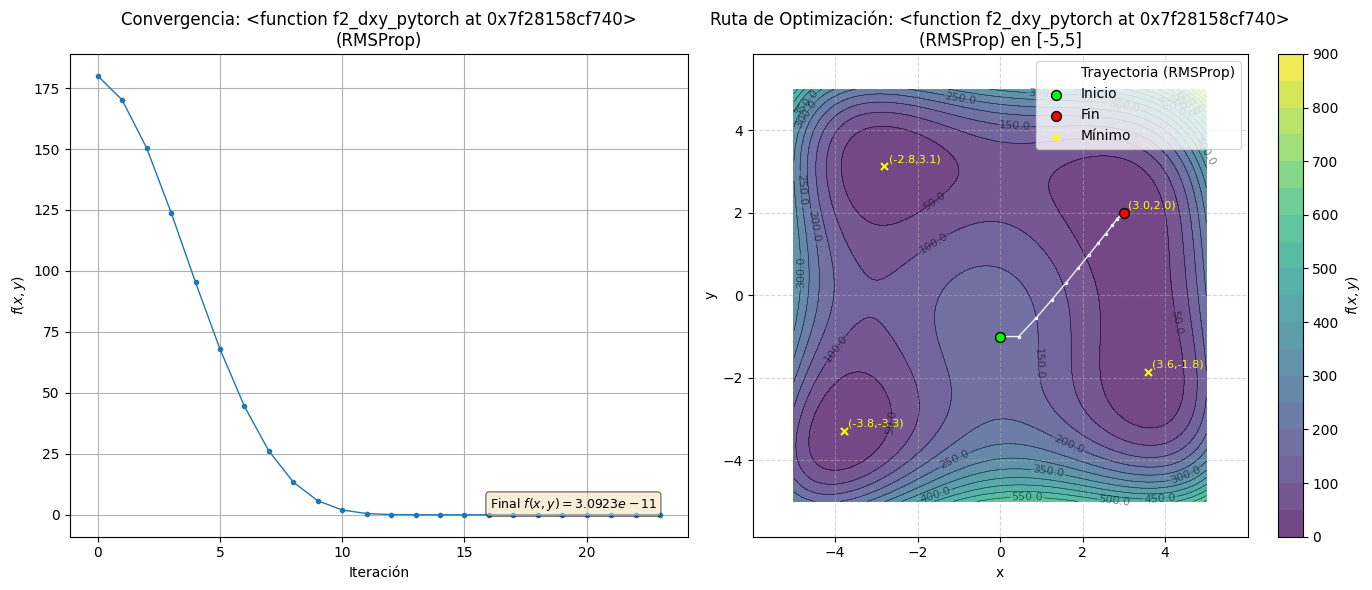


Last point (x, y):	(3.000, 2.000)
Expected point (x, y):	(3.000, 2.000)

** test_3: PASSED!


In [20]:
# Para Himmelblau (f2), Prueba (-1,-1), Mínimos (3,2), (-2.805, 3.131), (-3.779, -3.283) y (3.584, -1.848)
test_3_settings = {
  'optimizer_params': {
    'func_to_optimize': funcs_pytorch_labels[2][0],
    'derivative_func': funcs_pytorch_labels[2][1],
    'initial_params': torch.tensor([[0.0, -1.0]], requires_grad=False),
    'learning_rate': 0.2,
    'N': P,
    'gamma': 0.8,
    'epsilon': 1e-8,
    'history_params_x': [],
    'history_fx': [],
    'verbose': True
  },
  'expected_x_y': [(3, 2), (-2.805, 3.131), (-3.779, -3.283), (3.584, -1.848)],
  'test_tolerance': 1e-1,
  'plot': {
    'func_name_str':funcs_pytorch_labels[2][1],
    'optimizer_name_str': "RMSProp",
    'plot_range': (-5, 5),
    'mark_points': [(3, 2), (-2.805, 3.131), (-3.779, -3.283), (3.584, -1.848)],
    'points_label': 'Mínimo',
  }
}

test("test_3", **test_3_settings)

### a) Calibración (utilizando Optuna para RMSProp)

In [21]:
P = 500 # Cantidad de iteraciones
epsilon = 1e-8
min_lr = 1e-1
max_lr = 1.0
min_gamma = 0.5
max_gamma = 0.999

def random_point():
  x = random.uniform(-10, 10)
  y = random.uniform(-10, 10)
  return torch.tensor([[x, y]], requires_grad=False)

# metrica RMSE
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))


def objective_rms_prop_f0(trial):
  """!
  @brief Función objetivo para Optuna para calibrar RMSprop. # Función Objetivo para Optuna

  @param trial de Optuna, configura los hiperparámetros.
  @return Valor de la función objetivo, métrica a optimizar.
  """
  lr = trial.suggest_float('lr', min_lr, max_lr, log=True)
  gamma = trial.suggest_float('gamma', min_gamma, max_gamma, log=True)

  # Parámetros fijos
  iterations = P
  history_params_x = []

  final_value = rmsprop(**{
    'func_to_optimize': funcs_pytorch_labels[0][0],  #f0
    'derivative_func': funcs_pytorch_labels[0][1],
    'initial_params': random_point(),
    'learning_rate': lr,
    'N': iterations,
    'gamma': gamma,
    'epsilon': epsilon,
    'history_params_x': history_params_x,
    'verbose': False,
  })

  return final_value


def objective_rms_prop_f1(trial):
  """!
  @brief Función objetivo para Optuna para calibrar RMSprop. # Función Objetivo para Optuna

  @param trial de Optuna, configura los hiperparámetros.
  @return Valor de la función objetivo, métrica a optimizar.
  """
  lr = trial.suggest_float('lr', min_lr, max_lr, log=True)
  gamma = trial.suggest_float('gamma', min_gamma, max_gamma, log=True)

  # Parámetros fijos
  iterations = P
  history_params_x = []

  final_value = rmsprop(**{
    'func_to_optimize': funcs_pytorch_labels[1][0],  # f_1
    'derivative_func': funcs_pytorch_labels[1][1],
    'initial_params': random_point(),
    'learning_rate': lr,
    'N': iterations,
    'gamma': gamma,
    'epsilon': epsilon,
    'history_params_x': history_params_x,
    'verbose': False,
  })

  return final_value

def objective_rms_prop_f2(trial):
  """!
  @brief Función objetivo para Optuna para calibrar RMSprop. # Función Objetivo para Optuna

  @param trial de Optuna, configura los hiperparámetros.
  @return Valor de la función objetivo, métrica a optimizar.
  """
  lr = trial.suggest_float('lr', min_lr, max_lr, log=True)
  gamma = trial.suggest_float('gamma', min_gamma, max_gamma, log=True)

  # Parámetros fijos
  iterations = P
  history_params_x = []

  final_value = rmsprop(**{
    'func_to_optimize': funcs_pytorch_labels[2][0],  # f_2
    'derivative_func': funcs_pytorch_labels[2][1],
    'initial_params': random_point(),
    'learning_rate': lr,
    'N': iterations,
    'gamma': gamma,
    'epsilon': epsilon,
    'history_params_x': history_params_x,
    'verbose': False,
  })

  return final_value

#### Estudio de Optuna

In [22]:
from plotly.io import show

# Estudio de Optuna
n_trials = 100

def perform_study(function_to_optimize, study_name, trials=100, direction='minimize'):
  study_f = optuna.create_study(direction=direction, study_name=study_name)
  study_f.optimize(function_to_optimize, n_trials=trials, show_progress_bar=True) # Ajusta n_trials según sea necesario
  return study_f

#### Progreso de Calibracion para RMSProp

##### Calibración de $f_0$

In [23]:
study_rmsprop_f0 = perform_study(objective_rms_prop_f0, "rms_prop_f0_optimization", trials=n_trials)
best_trial_f0 = study_rmsprop_f0.best_trial

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
# Gráfica del historial de optimización: muestra cómo mejora el valor objetivo con cada trial.
fig_history = optuna.visualization.plot_optimization_history(study_rmsprop_f0)
fig_history.show()

In [25]:
# # Gráfica de coordenadas paralelas: muestra cómo diferentes combinaciones de hiperparámetros afectan el resultado.
fig_parallel_coordinate = optuna.visualization.plot_parallel_coordinate(study_rmsprop_f0)
fig_parallel_coordinate.show()



---



##### Calibración de $f_1$

In [26]:
study_rmsprop_f1 = perform_study(objective_rms_prop_f1, "rms_prop_f1_optimization", trials=n_trials)
best_trial_f1 = study_rmsprop_f1.best_trial

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
# Gráfica del historial de optimización: muestra cómo mejora el valor objetivo con cada trial.
fig_history = optuna.visualization.plot_optimization_history(study_rmsprop_f1)
fig_history.show()

In [28]:
# # Gráfica de coordenadas paralelas: muestra cómo diferentes combinaciones de hiperparámetros afectan el resultado.
fig_parallel_coordinate = optuna.visualization.plot_parallel_coordinate(study_rmsprop_f1)
fig_parallel_coordinate.show()



---



##### Calibración de $f_2$

In [29]:
study_rmsprop_f2 = perform_study(objective_rms_prop_f2, "rms_prop_f2_optimization", trials=n_trials)
best_trial_f2 = study_rmsprop_f2.best_trial

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
# Gráfica del historial de optimización: muestra cómo mejora el valor objetivo con cada trial.
fig_history = optuna.visualization.plot_optimization_history(study_rmsprop_f2)
fig_history.show()

In [31]:
# # Gráfica de coordenadas paralelas: muestra cómo diferentes combinaciones de hiperparámetros afectan el resultado.
fig_parallel_coordinate = optuna.visualization.plot_parallel_coordinate(study_rmsprop_f2)
fig_parallel_coordinate.show()



---



#### Valores obtenidos en la Calibración

In [32]:
rmsprop_optimization_best_values = []
for key, value in best_trial_f0.params.items():
    rmsprop_optimization_best_values.append(["f0", key, value])
for key, value in best_trial_f1.params.items():
    rmsprop_optimization_best_values.append(["f1", key, value])
for key, value in best_trial_f2.params.items():
    rmsprop_optimization_best_values.append(["f2", key, value])

rmsprop_optimization_best_values = pd.DataFrame(rmsprop_optimization_best_values,
                                                columns=["Funcion", "Hiperparametro", "mejor_valor"])
rmsprop_optimization_best_values

Funcion Hiperparametro  mejor_valor
0      f0             lr     0.480297
1      f0          gamma     0.770968
2      f1             lr     0.480874
3      f1          gamma     0.740045
4      f2             lr     0.173847
5      f2          gamma     0.758395

In [33]:
if not _REGENERATE:
  # Reutiliza optimizacion de corrida anterior para reproducir resultados analizados
  #  	Funcion 	Hiperparametro 	mejor_valor
  # 0 	f0 	lr 	0.483789
  # 1 	f0 	gamma 	0.747768
  # 2 	f1 	lr 	0.451939
  # 3 	f1 	gamma 	0.614229
  # 4 	f2 	lr 	0.152503
  # 5 	f2 	gamma 	0.771545
  rmsprop_optimization_best_values = pd.DataFrame({
      'Funcion': ['f0', 'f0', 'f1', 'f1', 'f2', 'f2'],
      'Hiperparametro': ['lr', 'gamma', 'lr', 'gamma', 'lr', 'gamma'],
      'mejor_valor': [0.483789, 0.747768, 0.451939, 0.614229, 0.152503, 0.771545]
  })

rmsprop_optimization_best_values

Funcion Hiperparametro  mejor_valor
0      f0             lr     0.483789
1      f0          gamma     0.747768
2      f1             lr     0.451939
3      f1          gamma     0.614229
4      f2             lr     0.152503
5      f2          gamma     0.771545

### b) Realice lo anterior para el algoritmo del descenso del gradiente (SGD).

In [34]:
def sgd(func_to_optimize, derivative_func, initial_params, learning_rate=0.1, N=100, epsilon=1e-8, history_params_x=[],
        history_fx=[], clip_gradient=False, verbose=False):
  """!
  @brief Implementa el algoritmo clásico de Descenso de Gradiente usando PyTorch
         para optimizar una función de dos variables f(x,y), aceptando
         hiperparámetros y opciones de control vía kwargs.

  @param func_to_optimize La función a optimizar. Debe tomar dos tensores de PyTorch (x, y) y devolver un tensor.
  @param func_to_optimize (callable): La función a optimizar.
  @param derivative_func (callable): La derivada de la función a optimizar.
  @param params_t (Tensor, opcional): Tensor (x_init, y_init) con los valores iniciales.
  @param learning_rate (float, opcional): Tasa de aprendizaje (alpha).
                                          Por defecto: 0.01.
  @param N (int, opcional): Número de iteraciones.
                            Por defecto: 100.
  @param epsilon (float, opcional): Pequeño valor para evitar la división por cero.
                                    Por defecto: 1e-8.
  @param history_params_x (list, opcional): Lista de tuplas (x,y) que representan la trayectoria de los parámetros.
                                            Por defecto: [].
  @param history_fx (list, opcional): Lista de los valores de la función f(x,y) en cada iteración.
                                      Por defecto: [].
  @param clip_gradient (bool, opcional): Si True, normaliza el gradiente para evitar gradientes muy altos.
                                         Por defecto: False.
  @param verbose (bool, opcional): Si True, imprime información durante la ejecución.
                                Por defecto: False.

  @return Valor final de la funcion a optimizar.
  """
  params_t = initial_params.clone()
  current_f_val = torch.sum(func_to_optimize(params_t)).item()

  history_params_x.append((params_t[:, 0].item(), params_t[:, 1].item()))
  history_fx.append(current_f_val)

  if verbose:
    print(f"Initial: params_t = ({params_t}), f(params_t) = {current_f_val:.4f}")

  for i in range(N):
    grad = derivative_func(params_t)

    # en el caso de f_2, a veces la gradiente explota y hace que se salte el
    # minimo y la funcion dispare a infinito.
    # Por eso este codigo busca normalizar el gradiente
    grad_norm = torch.norm(grad)
    max_grad_norm = 1.0 # Define un umbral
    if clip_gradient and grad_norm > max_grad_norm:
      grad = grad * (max_grad_norm / grad_norm)

    params_t -= learning_rate * grad

    # Guarda historial
    x_updated, y_updated = params_t[:, 0], params_t[:, 1]
    history_params_x.append((x_updated.item(), y_updated.item()))

    updated_f_val = torch.sum(func_to_optimize(params_t)).item()
    history_fx.append(updated_f_val)

    if verbose and (i + 1) % (N // 10 if N >= 10 else 1) == 0 or N < 10:
      print(f"Iter {i+1}/{N}: f({x_updated.item()},\t{y_updated.item()})\t=\t{updated_f_val},\tgrad=[{grad}]")

    if np.abs(current_f_val - updated_f_val) < epsilon:
      if verbose:
        print(f"\n*** Iter {i+1}: CONVERGIO! en f({x_updated.item()},\t{y_updated.item()})\t=\t{updated_f_val}...\n")
      break
    current_f_val = updated_f_val

  return current_f_val

# Smoke test
history_params_test = []
# Smoke test
print("f(x,y):", sgd(**{
  'func_to_optimize': lambda x: x**2,
  'derivative_func': lambda x: 2*x,
  'initial_params': torch.tensor([[-3.0, 4.0]], dtype=torch.float32, requires_grad=False),
  'learning_rate': 0.1,
  'N': 100,
  'history_params_x': history_params_test,
  'history_fx': [],
  'verbose': True
}), "| (x,y):", history_params_test[-1], "| iteraciones:", len(history_params_test)-1)
del(history_params_test)

Initial: params_t = (tensor([[-3.,  4.]])), f(params_t) = 25.0000
Iter 10/100: f(-0.32212257385253906,	0.4294966757297516)	=	0.28823035955429077,	grad=[tensor([[-0.8053,  1.0737]])]
Iter 20/100: f(-0.03458765149116516,	0.04611685872077942)	=	0.003323070239275694,	grad=[tensor([[-0.0865,  0.1153]])]
Iter 30/100: f(-0.003713820595294237,	0.004951760172843933)	=	3.831239155260846e-05,	grad=[tensor([[-0.0093,  0.0124]])]
Iter 40/100: f(-0.00039876840310171247,	0.0005316912429407239)	=	4.417117906996282e-07,	grad=[tensor([[-0.0010,  0.0013]])]

*** Iter 48: CONVERGIO! en f(-6.690224108751863e-05,	8.920299296732992e-05)	=	1.243308389575759e-08...

f(x,y): 1.9426693143032026e-08 | (x,y): (-6.690224108751863e-05, 8.920299296732992e-05) | iteraciones: 48


#### Unit tests de `sdg`

Initial: params_t = (tensor([[-3.,  4.]])), f(params_t) = 25.0000
Iter 10/100: f(-0.32212257385253906,	0.4294966757297516)	=	0.28823035955429077,	grad=[tensor([[-0.8053,  1.0737]])]
Iter 20/100: f(-0.03458765149116516,	0.04611685872077942)	=	0.003323070239275694,	grad=[tensor([[-0.0865,  0.1153]])]
Iter 30/100: f(-0.003713820595294237,	0.004951760172843933)	=	3.831239155260846e-05,	grad=[tensor([[-0.0093,  0.0124]])]
Iter 40/100: f(-0.00039876840310171247,	0.0005316912429407239)	=	4.417117906996282e-07,	grad=[tensor([[-0.0010,  0.0013]])]

*** Iter 48: CONVERGIO! en f(-6.690224108751863e-05,	8.920299296732992e-05)	=	1.243308389575759e-08...



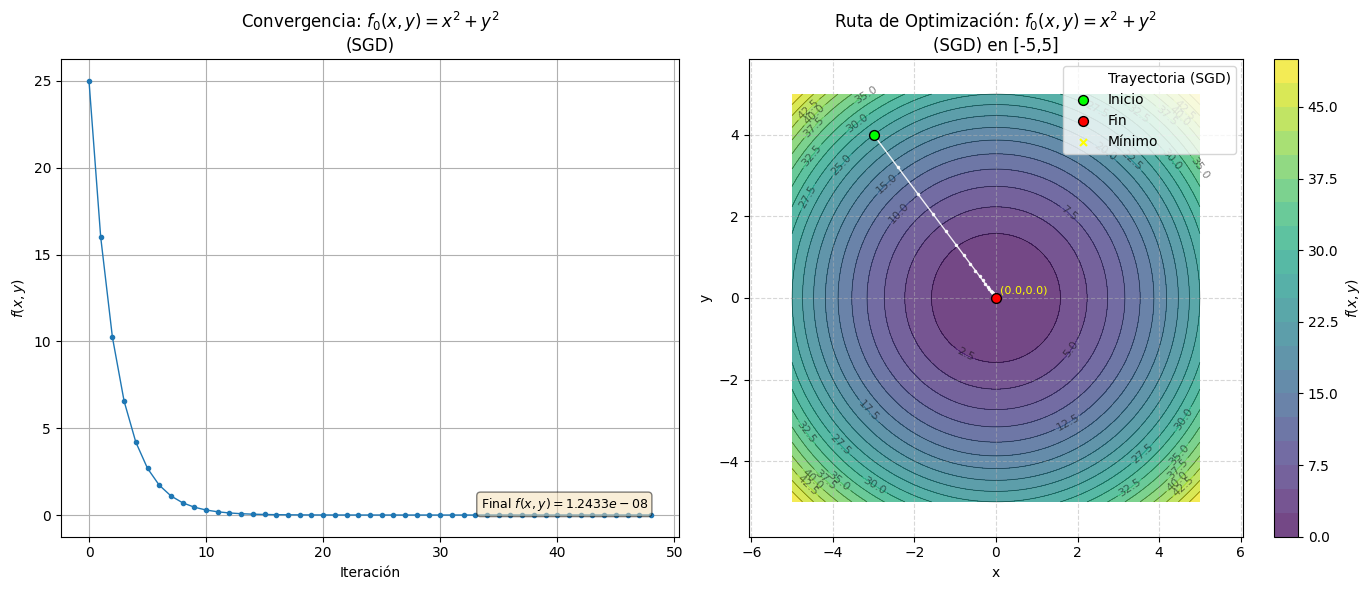


Last point (x, y):	(-0.000, 0.000)
Expected point (x, y):	(0.000, 0.000)

** test_1: FAILED!


In [35]:
P = 100
# Para f0, prueba desde (-3, 4), mínimo global: (0,0)
test_1_settings = {
  'optimizer_params': {
    'func_to_optimize': funcs_pytorch_labels[0][0],
    'derivative_func': funcs_pytorch_labels[0][1],
    'initial_params': torch.tensor([[-3.0, 4.0]], dtype=torch.float32, requires_grad=False),
    'learning_rate': 0.1,
    'N': P,
    'history_params_x': [],
    'history_fx': [],
    'verbose': True
  },
  'expected_x_y': [(0.0, 0.0)],
  'test_tolerance': 1e-8,
  'plot': {
    'func_name_str':funcs_pytorch_labels[0][2],
    'optimizer_name_str': "SGD",
    'plot_range': (-5, 5),
    'mark_points': [(0, 0)],
    'points_label': 'Mínimo',
  }
}

test("test_1", optimizer=sgd, **test_1_settings)


Initial: params_t = (tensor([[-3.,  4.]])), f(params_t) = 10.1386
Iter 10/100: f(-2.183586359024048,	3.8489322662353516)	=	10.383238792419434,	grad=[tensor([[4.3943, 1.9288]])]
Iter 20/100: f(-2.2598555088043213,	3.779531717300415)	=	10.925878524780273,	grad=[tensor([[3.5954, 3.0849]])]
Iter 30/100: f(-1.4941041469573975,	3.825496196746826)	=	10.766925811767578,	grad=[tensor([[-0.2864, -0.3842]])]
Iter 40/100: f(-0.9607718586921692,	4.027217388153076)	=	8.92387580871582,	grad=[tensor([[-0.3903, -1.4101]])]
Iter 50/100: f(-1.1833263635635376,	3.8051226139068604)	=	9.882284164428711,	grad=[tensor([[4.2430, 3.2665]])]
Iter 60/100: f(-0.705514669418335,	4.0731377601623535)	=	10.20809268951416,	grad=[tensor([[-4.9012, -2.4560]])]
Iter 70/100: f(-0.9961601495742798,	3.8646585941314697)	=	9.051722526550293,	grad=[tensor([[-3.0599, -1.1488]])]
Iter 80/100: f(-1.1385719776153564,	3.8783390522003174)	=	9.446252822875977,	grad=[tensor([[1.8061, 0.9660]])]
Iter 90/100: f(-1.028052568435669,	3.8968

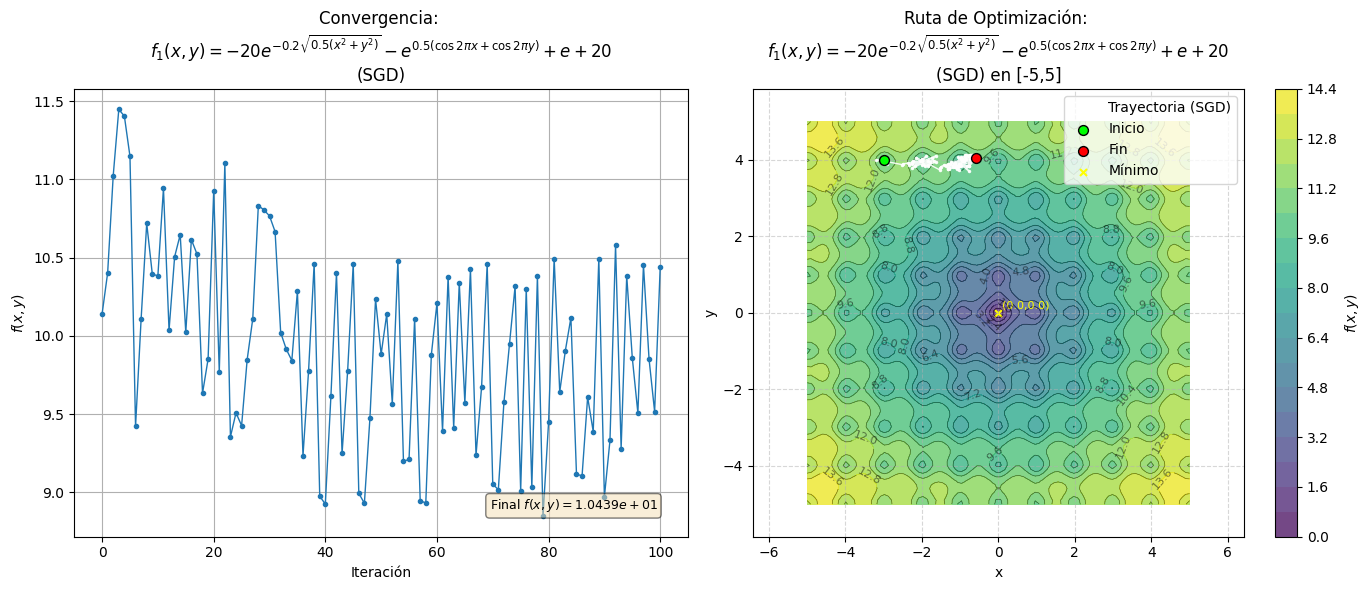


Last point (x, y):	(-0.595, 4.048)
Expected point (x, y):	(-0.595, 4.048)

** test_2: PASSED!


In [36]:
# Ackley (f1), prueba desde (-3, 4), mínimo global: (0,0)
test_2_settings = {
  'optimizer_params': {
    'func_to_optimize': funcs_pytorch_labels[1][0],
    'derivative_func': funcs_pytorch_labels[1][1],
    'initial_params': torch.tensor([[-3.0, 4.0]], dtype=torch.float32, requires_grad=False),
    'learning_rate': 0.1,
    'N': P,
    'history_params_x': [],
    'history_fx': [],
    'verbose': True
  },
  'expected_x_y': [(-0.595, 4.048)],
  'test_tolerance': 1e-2,
  'plot': {
    'func_name_str': '\n'+funcs_pytorch_labels[1][2],
    'optimizer_name_str': "SGD",
    'plot_range': (-5, 5),
    'mark_points': [(0, 0)],
    'points_label': 'Mínimo',
  }
}

test("test_2", optimizer=sgd, **test_2_settings)

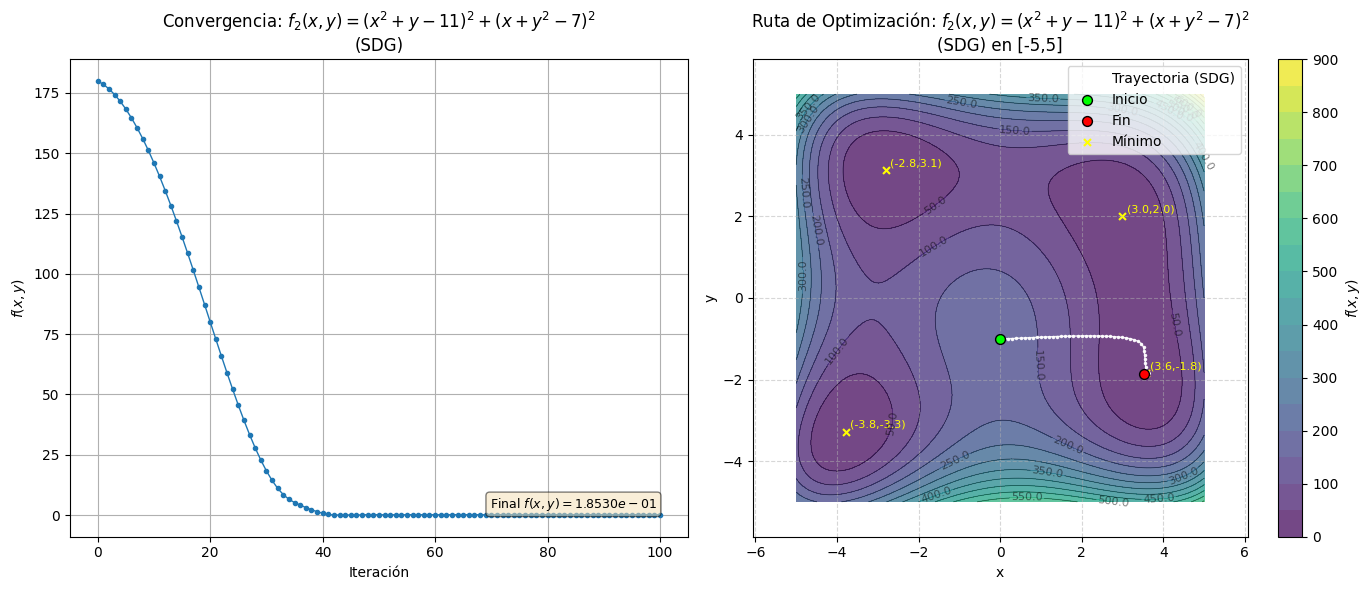


Last point (x, y):	(3.525, -1.853)
Expected point (x, y):	(3.000, 2.000)
Expected point (x, y):	(-2.805, 3.131)
Expected point (x, y):	(-3.779, -3.283)
Expected point (x, y):	(3.584, -1.848)

** test_3: PASSED!


In [37]:
# Para Himmelblau (f2), Prueba (-1,-1), Mínimos (3,2), (-2.805, 3.131), (-3.779, -3.283) y (3.584, -1.848)
test_3_settings = {
  'optimizer_params': {
    'func_to_optimize': funcs_pytorch_labels[2][0],
    'derivative_func': funcs_pytorch_labels[2][1],
    'initial_params': torch.tensor([[0.0, -1.0]], dtype=torch.float32, requires_grad=False),
    'learning_rate': 0.1,
    'N': P,
    'epsilon': 1e-4,
    'history_params_x': [],
    'history_fx': [],
    'clip_gradient': True,
    'verbose': False
  },
  'expected_x_y': [(3, 2), (-2.805, 3.131), (-3.779, -3.283), (3.584, -1.848)],
  'test_tolerance': 1e-1,
  'plot': {
    'func_name_str':funcs_pytorch_labels[2][2],
    'optimizer_name_str': "SDG",
    'plot_range': (-5, 5),
    'mark_points': [(3, 2), (-2.805, 3.131), (-3.779, -3.283), (3.584, -1.848)],
    'points_label': 'Mínimo',
  }
}

test("test_3", optimizer=sgd, **test_3_settings)

#### Calibración (utilizando Optuna para SGD)

In [38]:
P = 500 # Cantidad de iteraciones
epsilon = 1e-8
min_lr = 1e-1
max_lr = 1.0

f2_min_lr = 1e-2
f2_max_lr = 2e-1


def objective_sgd_f0(trial):
  """!
  @brief Función objetivo para Optuna para calibrar SGD.

  @param trial de Optuna, configura los hiperparámetros.
  @return Valor de la función objetivo, métrica a optimizar.
  """
  lr = trial.suggest_float('lr', min_lr, max_lr, log=True)

  # Parámetros fijos
  iterations = P

  final_value = sgd(**{
    'func_to_optimize': funcs_pytorch_labels[0][0],  # f_0
    'derivative_func': funcs_pytorch_labels[0][1],
    'initial_params': random_point(),
    'learning_rate': lr,
    'N': iterations,
    'epsilon': epsilon,
  })

  return final_value

def objective_sgd_f1(trial):
  """!
  @brief Función objetivo para Optuna para calibrar SGD.

  @param trial de Optuna, configura los hiperparámetros.
  @return Valor de la función objetivo, métrica a optimizar.
  """
  lr = trial.suggest_float('lr', min_lr, max_lr, log=True)

  # Parámetros fijos
  iterations = P

  final_value = sgd(**{
    'func_to_optimize': funcs_pytorch_labels[1][0],  # f_1
    'derivative_func': funcs_pytorch_labels[1][1],
    'initial_params': random_point(),
    'learning_rate': lr,
    'N': iterations,
  })

  return final_value


def objective_sgd_f2(trial):
  """!
  @brief Función objetivo para Optuna para calibrar SGD.

  @param trial de Optuna, configura los hiperparámetros.
  @return Valor de la función objetivo, métrica a optimizar.
  """
  lr = trial.suggest_float('lr', f2_min_lr, f2_max_lr, log=True)

  # Parámetros fijos
  iterations = P

  final_value = sgd(**{
    'func_to_optimize': funcs_pytorch_labels[2][0],  # f_2
    'derivative_func': funcs_pytorch_labels[2][1],
    'initial_params': random_point(),
    'learning_rate': lr,
    'N': iterations,
    'epsilon': epsilon,
    'clip_gradient': True,
  })

  return final_value


##### Estudio de Optuna

###### Calibración de $f_0$

In [39]:
sgd_study_f0 = perform_study(objective_sgd_f0, "sgd_f0_optimization", n_trials)
sgd_best_trial_f0 = sgd_study_f0.best_trial

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
# Gráfica del historial de optimización: muestra cómo mejora el valor objetivo con cada trial.
fig_history = optuna.visualization.plot_optimization_history(sgd_study_f0)
fig_history.show()

In [41]:
# Gráfica de coordenadas paralelas: muestra cómo diferentes combinaciones de hiperparámetros afectan el resultado.
fig_parallel_coordinate = optuna.visualization.plot_parallel_coordinate(sgd_study_f0)
fig_parallel_coordinate.show()



---



###### Calibración de $f_1$

In [42]:
sgd_study_f1 = perform_study(objective_sgd_f1, "sgd_f1_optimization", n_trials)
sgd_best_trial_f1 = sgd_study_f1.best_trial

  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
# Gráfica del historial de optimización: muestra cómo mejora el valor objetivo con cada trial.
fig_history = optuna.visualization.plot_optimization_history(sgd_study_f1)
fig_history.show()

In [44]:
# Gráfica de coordenadas paralelas: muestra cómo diferentes combinaciones de hiperparámetros afectan el resultado.
fig_parallel_coordinate = optuna.visualization.plot_parallel_coordinate(sgd_study_f1)
fig_parallel_coordinate.show()



---


###### Calibración de $f_2$

In [45]:
sgd_study_f2 = perform_study(objective_sgd_f2, "sgd_f2_optimization", n_trials)
sgd_best_trial_f2 = sgd_study_f2.best_trial

  0%|          | 0/100 [00:00<?, ?it/s]

In [46]:
# Gráfica del historial de optimización: muestra cómo mejora el valor objetivo con cada trial.
fig_history = optuna.visualization.plot_optimization_history(sgd_study_f2)
fig_history.show()

In [47]:
# Gráfica de coordenadas paralelas: muestra cómo diferentes combinaciones de hiperparámetros afectan el resultado.
fig_parallel_coordinate = optuna.visualization.plot_parallel_coordinate(sgd_study_f2)
fig_parallel_coordinate.show()



---



###### Valores obtenidos en la calibración

In [48]:
sgd_optimization_best_values = []
for key, value in sgd_best_trial_f0.params.items():
    sgd_optimization_best_values.append(["f0", key, value])
for key, value in sgd_best_trial_f1.params.items():
    sgd_optimization_best_values.append(["f1", key, value])
for key, value in sgd_best_trial_f2.params.items():
    sgd_optimization_best_values.append(["f2", key, value])

sgd_optimization_best_values = pd.DataFrame(sgd_optimization_best_values,
                                            columns=["Funcion", "Hiperparametro", "mejor_valor"])
sgd_optimization_best_values

Funcion Hiperparametro  mejor_valor
0      f0             lr     0.497539
1      f1             lr     0.167613
2      f2             lr     0.014117

In [49]:
if not _REGENERATE:
  # Reutiliza optimizacion de corrida anterior para reproducir resultados analizados
  #  	Funcion 	Hiperparametro 	mejor_valor
  # 0 	f0 	lr 	0.498365
  # 2 	f1 	lr 	0.180285
  # 4 	f2 	lr 	0.013659
  sgd_optimization_best_values = pd.DataFrame({
      'Funcion': ['f0', 'f1', 'f2'],
      'Hiperparametro': ['lr', 'lr', 'lr'],
      'mejor_valor': [0.498365, 0.180285, 0.13659]
  })

sgd_optimization_best_values

Funcion Hiperparametro  mejor_valor
0      f0             lr     0.498365
1      f1             lr     0.180285
2      f2             lr     0.136590

### c) ¿Porqué el algoritmo RMS prop es más efectivo en evitar atascarse en puntos silla que el algoritmo del descenso del gradiente?



*   El algoritmo de RMSProp tiene un elemento de momentum que lo impulsa y le permite salir de mínimos locales de forma más efectiva que el descenso de gradiente, el cual lleva una tasa de aprendizaje constante, y si esta es pequeña, es muy probable que se atore en un mínimo local, sobre todo en el caso de $f1$.
*   El descenso de gradiente, es un algoritmo que es mas efectivo en $f_0$, notamos que llega casi directo en un salto, dependiendo de la tasa de aprendizaje, en esta función puede tener $\alpha$ grandes en realidad. Se comporta muy bien en el caso de la función convexa $f_0$.

### d) Para los mejores valores encontrados, en cada funcion, por un máximo de 50 iteraciones (para el algoritmo del descenso del gradiente, y RMS prop):


  *    1) Ejecute el algoritmo 10 corridas diferentes, y documente en una tabla la cantidad de iteraciones para converger a el o los puntos minimos (indique si convergió).
  *    2) Muestre el valor promedio de la función minimizada para las 10 corridas, y la cantidad de iteraciones promedio en converger.

In [50]:
from dataclasses import dataclass, asdict
from tabulate import tabulate
from typing import List, Tuple
from pprint import pprint as pp

@dataclass
class RunHistory:
  optimizer: str
  function: str
  iterations_history: list
  convergence_history: list
  average_fx: float
  average_iterations: float
  best_run_number_of_iterations: float
  best_run_history_route: List[Tuple[float, float]]
  best_run_history_values: List[float]


run_history_list = []

# Valores fijos
P = 50
test_tolerance = 1e-8
epsilon= 1e-8


def evaluate_optimizer(func_name, func_to_optimize, derivative_func, optimizer_name, optimizer, function_minimums=[],
                       test_points=[], test_tolerance=test_tolerance, epsilon=epsilon, epochs=P, lr=0.01, gamma=0.99,
                       clip_gradient=False):
  """!
      @brief: Ejecutor de pruebas, realiza una corrida para cada punto en test_points, y devuelve un DataFrame con los resultados.

      @param func_name (str): Nombre de la función.
      @param func_to_optimize (callable): Función a optimizar.
      @param derivative_func (callable): Derivada de la función a optimizar.
      @param optimizer_name (str): Nombre del optimizador, valores aceptados: RMSProp, SGD.
      @param optimizer (callable): Función del optimizador.
      @param function_minimums (list): Lista de tensores, cada tensor es un mínimos de la función a optimizar.
      @param test_points (list): Lista de puntos a evaluar.
      @param test_tolerance (float): Tolerancia para evaluar si hubo convergencia.
      @param epsilon (float): Tolerancia para la convergencia.
      @param epochs (int): Cantidad de iteraciones del optimizador.
      @param lr (float): Tasa de aprendizaje.
      @param gamma (float): Factor de decaimiento.
      @param clip_gradient (bool): Si True, normaliza el gradiente para evitar gradientes muy altos.

      @return Diccionario con los resultados.
  """

  hist_iterations = []
  hist_converged = []
  hist_fx = []

  best_run_history_params_x: List[Tuple[float, float]] = []
  best_run_history_values: List[float] = []
  best_run_iterations = float('inf')
  the_best_converged = False

  test_run = 1
  for point in test_points:
    initial_point = point.clone()

    # print(f"\nCorrida {i}, {func_name}({point})")
    test_run += 1

    history_params_x = []
    history_fx= []
    fx = float('inf')
    if optimizer_name == 'RMSProp':
      fx = optimizer(**{
        'func_to_optimize': func_to_optimize,
        'derivative_func': derivative_func,
        'initial_params': initial_point,
        'learning_rate': lr,
        'N': epochs,
        'gamma': gamma,
        'epsilon': epsilon,
        'history_params_x': history_params_x,
        'history_fx': history_fx,
        'verbose': False,
      })
    else:
      fx = optimizer(**{
        'func_to_optimize': func_to_optimize,
        'derivative_func': derivative_func,
        'initial_params': initial_point,
        'learning_rate': lr,
        'N': epochs,
        'epsilon': epsilon,
        'history_params_x': history_params_x,
        'history_fx': history_fx,
        'verbose': False,
        'clip_gradient': clip_gradient,
      })

    iterations = len(history_params_x)-1 # history_params_x[0] es el punto inicial.
    converged = any([abs(fx - minimo) <= test_tolerance for minimo in function_minimums])
    hist_iterations.append(iterations)
    hist_converged.append(converged)
    hist_fx.append(fx)

    # Prueba si esta corrida es mejor que la mejor registrada
    if (iterations < best_run_iterations) and ((the_best_converged and converged) or (not the_best_converged)):
      best_run_iterations = iterations
      best_run_history_params_x = history_params_x
      best_run_history_values = history_fx
      the_best_converged = converged


  runs_df = pd.DataFrame({
      'Iteraciones': hist_iterations,
      'f(x)': hist_fx,
      'Convergio': hist_converged,
  })
  print(tabulate(runs_df, headers='keys', tablefmt='psql'))

  return RunHistory(
      optimizer_name,
      func_name,
      hist_iterations,
      hist_converged,
      runs_df['f(x)'].mean(),
      runs_df['Iteraciones'].mean(),
      best_run_iterations,
      best_run_history_params_x,
      best_run_history_values,
  )


In [51]:
NUMBER_OF_TEST_POINTS = 10
test_points = []

if _REGENERATE:
  # Generacion de puntos nuevos:
  test_points = [random_point() for _ in range(NUMBER_OF_TEST_POINTS)]
else:
  # Reutilizacion de puntos generados en corrida anterior (para reproducibilidad)

  test_points = [
    torch.tensor([[1.0285, 0.0047  ]], dtype=torch.float32),
    torch.tensor([[-6.6038,  2.4753]], dtype=torch.float32),
    torch.tensor([[-8.2054, -2.8204]], dtype=torch.float32),
    torch.tensor([[-8.5112,  1.3268]], dtype=torch.float32),
    torch.tensor([[ 4.5754, -3.7601]], dtype=torch.float32),
    torch.tensor([[1.8945, 2.8303  ]], dtype=torch.float32),
    torch.tensor([[3.9918, 5.3680  ]], dtype=torch.float32),
    torch.tensor([[ 3.9152, -8.9213]], dtype=torch.float32),
    torch.tensor([[ 6.9419, -5.1910]], dtype=torch.float32),
    torch.tensor([[-2.0934, -9.7509]], dtype=torch.float32)
  ]

test_points

[tensor([[1.0285, 0.0047]]),
 tensor([[-6.6038,  2.4753]]),
 tensor([[-8.2054, -2.8204]]),
 tensor([[-8.5112,  1.3268]]),
 tensor([[ 4.5754, -3.7601]]),
 tensor([[1.8945, 2.8303]]),
 tensor([[3.9918, 5.3680]]),
 tensor([[ 3.9152, -8.9213]]),
 tensor([[ 6.9419, -5.1910]]),
 tensor([[-2.0934, -9.7509]])]

#### RMSProp, $f_0$ (10 corridas, mejores hiperparámetros)

In [52]:
_f_name = 'f0'
rmsprop_optimization_best_values[rmsprop_optimization_best_values["Funcion"] == _f_name]

Funcion Hiperparametro  mejor_valor
0      f0             lr     0.483789
1      f0          gamma     0.747768

In [53]:
run_history_list.append(evaluate_optimizer(**{
  'func_name': _f_name,
  'func_to_optimize': funcs_pytorch_labels[0][0],
  'derivative_func': funcs_pytorch_labels[0][1],
  'optimizer_name': 'RMSProp',
  'optimizer': rmsprop,
  'function_minimums': [0.0],
  'lr': rmsprop_optimization_best_values[rmsprop_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[0],
  'gamma': rmsprop_optimization_best_values[rmsprop_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[1],
  'test_points': test_points,
}))
len(run_history_list)

+----+---------------+-------------+-------------+
|    |   Iteraciones |        f(x) | Convergio   |
|----+---------------+-------------+-------------|
|  0 |            50 | 0.117097    | False       |
|  1 |            50 | 0.152501    | False       |
|  2 |            50 | 0.064987    | False       |
|  3 |            50 | 0.0634708   | False       |
|  4 |            19 | 4.12976e-11 | True        |
|  5 |            13 | 8.83365e-11 | True        |
|  6 |            21 | 8.54402e-10 | True        |
|  7 |            50 | 0.0867488   | False       |
|  8 |            26 | 3.28164e-11 | True        |
|  9 |            50 | 0.136165    | False       |
+----+---------------+-------------+-------------+


1

#### SGD, $f_0$ (10 corridas, mejores hiperparámetros)

In [54]:
_f_name = 'f0'
sgd_optimization_best_values[sgd_optimization_best_values["Funcion"] == _f_name]

Funcion Hiperparametro  mejor_valor
0      f0             lr     0.498365

In [55]:
run_history_list.append(evaluate_optimizer(**{
  'func_name': _f_name,
  'func_to_optimize': funcs_pytorch_labels[0][0],
  'derivative_func': funcs_pytorch_labels[0][1],
  'optimizer_name': 'SGD',
  'optimizer': sgd,
  'function_minimums': [0.0],
  'lr': rmsprop_optimization_best_values[rmsprop_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[0],
  'test_points': test_points,
}))
len(run_history_list)

+----+---------------+-------------+-------------+
|    |   Iteraciones |        f(x) | Convergio   |
|----+---------------+-------------+-------------|
|  0 |             4 | 1.22873e-09 | True        |
|  1 |             5 | 6.07298e-11 | True        |
|  2 |             5 | 9.19223e-11 | True        |
|  3 |             5 | 9.06e-11    | True        |
|  4 |             5 | 4.28241e-11 | True        |
|  5 |             5 | 1.41634e-11 | True        |
|  6 |             5 | 5.464e-11   | True        |
|  7 |             5 | 1.15897e-10 | True        |
|  8 |             5 | 9.17423e-11 | True        |
|  9 |             5 | 1.21445e-10 | True        |
+----+---------------+-------------+-------------+


2

#### RMSProp, $f_1$ (10 corridas, mejores hiperparámetros)

In [56]:
_f_name = 'f1'
rmsprop_optimization_best_values[rmsprop_optimization_best_values["Funcion"] == _f_name]

Funcion Hiperparametro  mejor_valor
2      f1             lr     0.451939
3      f1          gamma     0.614229

In [57]:
run_history_list.append(evaluate_optimizer(**{
  'func_name': _f_name,
  'func_to_optimize': funcs_pytorch_labels[1][0],
  'derivative_func': funcs_pytorch_labels[1][1],
  'optimizer_name': 'RMSProp',
  'optimizer': rmsprop,
  'function_minimums': [0.0],
  'lr': rmsprop_optimization_best_values[rmsprop_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[0],
  'gamma': rmsprop_optimization_best_values[rmsprop_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[1],
  'test_points': test_points,
}))
len(run_history_list)

+----+---------------+-----------+-------------+
|    |   Iteraciones |      f(x) | Convergio   |
|----+---------------+-----------+-------------|
|  0 |            50 |  0.315857 | False       |
|  1 |            50 |  4.52248  | False       |
|  2 |            50 | 10.2863   | False       |
|  3 |            50 |  8.37847  | False       |
|  4 |            50 |  8.83668  | False       |
|  5 |            50 |  1.26972  | False       |
|  6 |            50 |  2.82502  | False       |
|  7 |            50 | 16.9742   | False       |
|  8 |            50 |  6.27579  | False       |
|  9 |            50 | 16.9766   | False       |
+----+---------------+-----------+-------------+


3

#### SGD, $f_1$ (10 corridas, mejores hiperparámetros)

In [58]:
_f_name = 'f1'
sgd_optimization_best_values[sgd_optimization_best_values["Funcion"] == _f_name]

Funcion Hiperparametro  mejor_valor
1      f1             lr     0.180285

In [59]:
run_history_list.append(evaluate_optimizer(**{
  'func_name': _f_name,
  'func_to_optimize': funcs_pytorch_labels[1][0],
  'derivative_func': funcs_pytorch_labels[1][1],
  'optimizer_name': 'SGD',
  'optimizer': sgd,
  'function_minimums': [0.0],
  'lr': rmsprop_optimization_best_values[rmsprop_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[0],
  'test_points': test_points,
}))
len(run_history_list)

+----+---------------+----------+-------------+
|    |   Iteraciones |     f(x) | Convergio   |
|----+---------------+----------+-------------|
|  0 |            50 |  3.89484 | False       |
|  1 |            50 |  3.10533 | False       |
|  2 |            50 |  4.91007 | False       |
|  3 |            50 |  5.03426 | False       |
|  4 |            50 |  4.15305 | False       |
|  5 |            50 |  8.22848 | False       |
|  6 |            50 | 10.111   | False       |
|  7 |            50 |  6.6184  | False       |
|  8 |            50 |  4.27837 | False       |
|  9 |            50 | 15.4883  | False       |
+----+---------------+----------+-------------+


4

#### RMSProp, $f_2$ (10 corridas, mejores hiperparámetros)

In [60]:
_f_name = 'f2'
rmsprop_optimization_best_values[rmsprop_optimization_best_values["Funcion"] == _f_name]

Funcion Hiperparametro  mejor_valor
4      f2             lr     0.152503
5      f2          gamma     0.771545

In [61]:
run_history_list.append(evaluate_optimizer(**{
  'func_name': _f_name,
  'func_to_optimize': funcs_pytorch_labels[2][0],
  'derivative_func': funcs_pytorch_labels[2][1],
  'optimizer_name': 'RMSProp',
  'optimizer': rmsprop,
  'function_minimums': [0.0],
  'lr': rmsprop_optimization_best_values[rmsprop_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[0],
  'gamma': rmsprop_optimization_best_values[rmsprop_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[1],
  'test_points': test_points,
}))
len(run_history_list)

+----+---------------+--------------+-------------+
|    |   Iteraciones |         f(x) | Convergio   |
|----+---------------+--------------+-------------|
|  0 |            24 |  2.6339e-09  | True        |
|  1 |            50 |  0.245723    | False       |
|  2 |            50 |  0.614866    | False       |
|  3 |            50 |  0.000466795 | False       |
|  4 |            50 |  0.47582     | False       |
|  5 |            14 |  1.6189e-10  | True        |
|  6 |            50 |  0.59318     | False       |
|  7 |            50 | 22.1826      | False       |
|  8 |            46 |  9.09495e-12 | True        |
|  9 |            50 | 11.3151      | False       |
+----+---------------+--------------+-------------+


5

#### SGD, $f_2$ (10 corridas, mejores hiperparámetros)

In [62]:
_f_name = 'f2'
sgd_optimization_best_values[sgd_optimization_best_values["Funcion"] == _f_name]

Funcion Hiperparametro  mejor_valor
2      f2             lr      0.13659

In [63]:
run_history_list.append(evaluate_optimizer(**{
  'func_name': _f_name,
  'func_to_optimize': funcs_pytorch_labels[2][0],
  'derivative_func': funcs_pytorch_labels[2][1],
  'optimizer_name': 'SGD',
  'optimizer': sgd,
  'function_minimums': [0.0],
  'lr': rmsprop_optimization_best_values[rmsprop_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[0],
  'test_points': test_points,
  'clip_gradient': True,
}))
len(run_history_list)

+----+---------------+-----------+-------------+
|    |   Iteraciones |      f(x) | Convergio   |
|----+---------------+-----------+-------------|
|  0 |            50 | 0.285151  | False       |
|  1 |            50 | 0.0985017 | False       |
|  2 |            50 | 0.291371  | False       |
|  3 |            50 | 0.581683  | False       |
|  4 |            50 | 0.231351  | False       |
|  5 |            50 | 0.242307  | False       |
|  6 |            50 | 0.198789  | False       |
|  7 |            50 | 0.437831  | False       |
|  8 |            50 | 0.388606  | False       |
|  9 |            50 | 0.375395  | False       |
+----+---------------+-----------+-------------+


6

In [64]:
assert(len(run_history_list) == 6)

In [65]:
test_run_history = pd.DataFrame([asdict(run_history) for run_history in run_history_list])
test_run_history

optimizer function                        iterations_history  \
0   RMSProp       f0  [50, 50, 50, 50, 19, 13, 21, 50, 26, 50]   
1       SGD       f0            [4, 5, 5, 5, 5, 5, 5, 5, 5, 5]   
2   RMSProp       f1  [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]   
3       SGD       f1  [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]   
4   RMSProp       f2  [24, 50, 50, 50, 50, 14, 50, 50, 46, 50]   
5       SGD       f2  [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]   

                                 convergence_history    average_fx  \
0  [False, False, False, False, True, True, True,...  6.209696e-02   
1  [True, True, True, True, True, True, True, Tru...  1.912694e-10   
2  [False, False, False, False, False, False, Fal...  7.666106e+00   
3  [False, False, False, False, False, False, Fal...  6.582207e+00   
4  [True, False, False, False, False, True, False...  3.542767e+00   
5  [False, False, False, False, False, False, Fal...  3.130984e-01   

   average_iterations  best_run_number_of_iterations  \
0                37.9                             13   
1                 4.9                              4   
2                50.0                             50   
3                50.0                             50   
4                43.4                             14   
5                50.0                             50   

                              best_run_history_route  \
0  [(1.8945000171661377, 2.8303000926971436), (0....   
1  [(1.028499960899353, 0.004699999932199717), (0...   
2  [(1.028499960899353, 0.004699999932199717), (0...   
3  [(1.028499960899353, 0.004699999932199717), (-...   
4  [(1.8945000171661377, 2.8303000926971436), (2....   
5  [(1.028499960899353, 0.004699999932199717), (1...   

                             best_run_history_values  
0  [11.59972858428955, 4.3528923988342285, 1.8526...  
1  [1.057834267616272, 0.001111982623115182, 1.16...  
2  [2.7296295166015625, 4.029540061950684, 5.7750...  
3  [2.7296295166015625, 3.106281280517578, 6.3343...  
4  [29.42120933532715, 15.190191268920898, 8.1225...  
5  [134.41221618652344, 125.51615905761719, 116.1...

### e) Muestre los puntos visitados del algoritmo para la mejor corrida (convergencia mas rapida) para cada función. Para ello use el gráfico de las curvas de nivel. Además para tales corridas, grafique la curva de aprendizaje.


---



In [66]:
import warnings

def plot_the_best(optimizer_name, function_name, func_number, run_history, plot_range = (-5, 5), mark_points = [(0, 0)]):
  warnings.filterwarnings('ignore')
  rmsprop_f0_best = run_history[run_history['optimizer']==optimizer_name][run_history['function']==function_name]['best_run_history_route'].iloc[0]
  history_fx_best = run_history[run_history['optimizer']==optimizer_name][run_history['function']==function_name]['best_run_history_values'].iloc[0]

  plot_optimization_results(
    funcs_pytorch_labels[func_number][0],
    rmsprop_f0_best,
    history_fx_best,
    funcs_pytorch_labels[func_number][2],
    optimizer_name,
    plot_range,
    mark_points,
    points_label = 'Mínimo',
  )

#### El mejor RMSProp, $f_0$

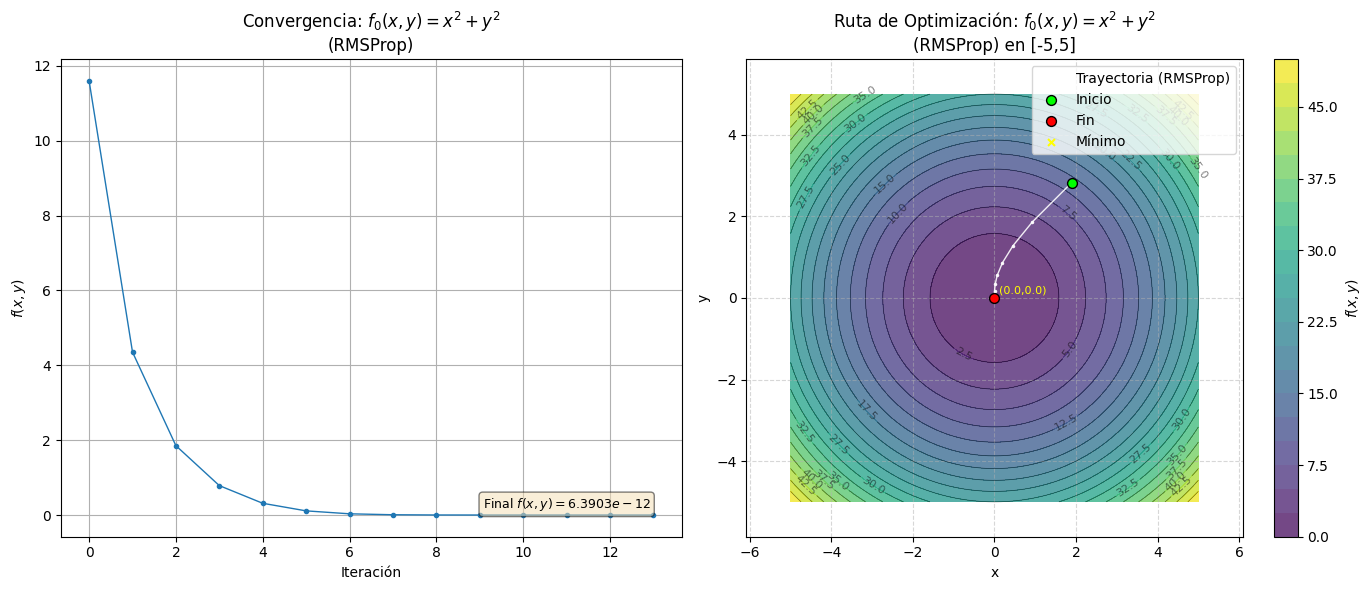

In [67]:
plot_the_best('RMSProp', 'f0', 0, test_run_history)

#### El mejor SGD, $f_0$

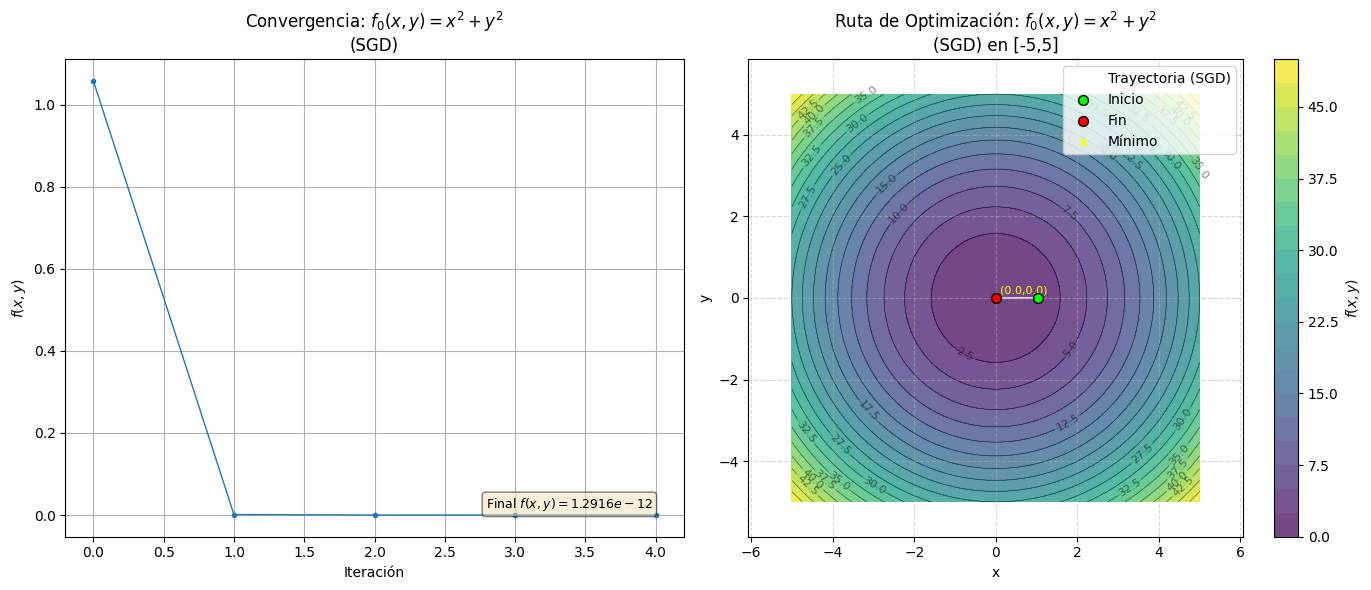

In [68]:
plot_the_best('SGD', 'f0', 0, test_run_history)

#### El mejor RMSProp, $f_1$

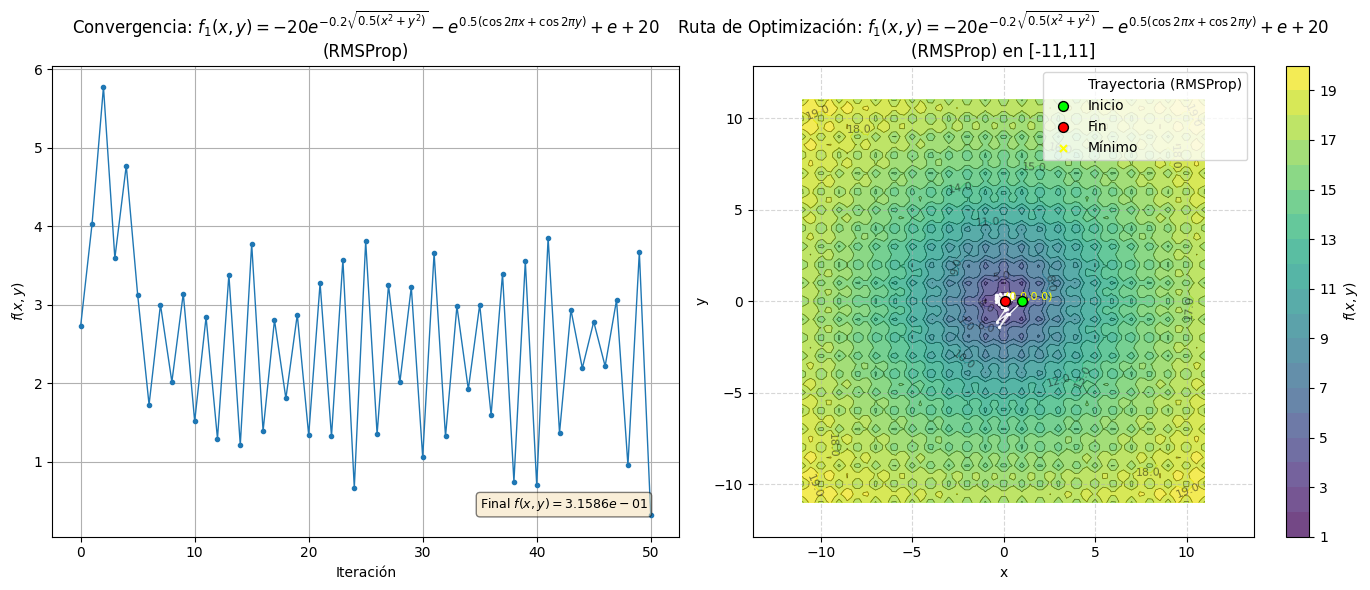

In [69]:
plot_the_best('RMSProp', 'f1', 1, test_run_history, plot_range=(-11, 11))

#### El mejor SGD, $f_1$

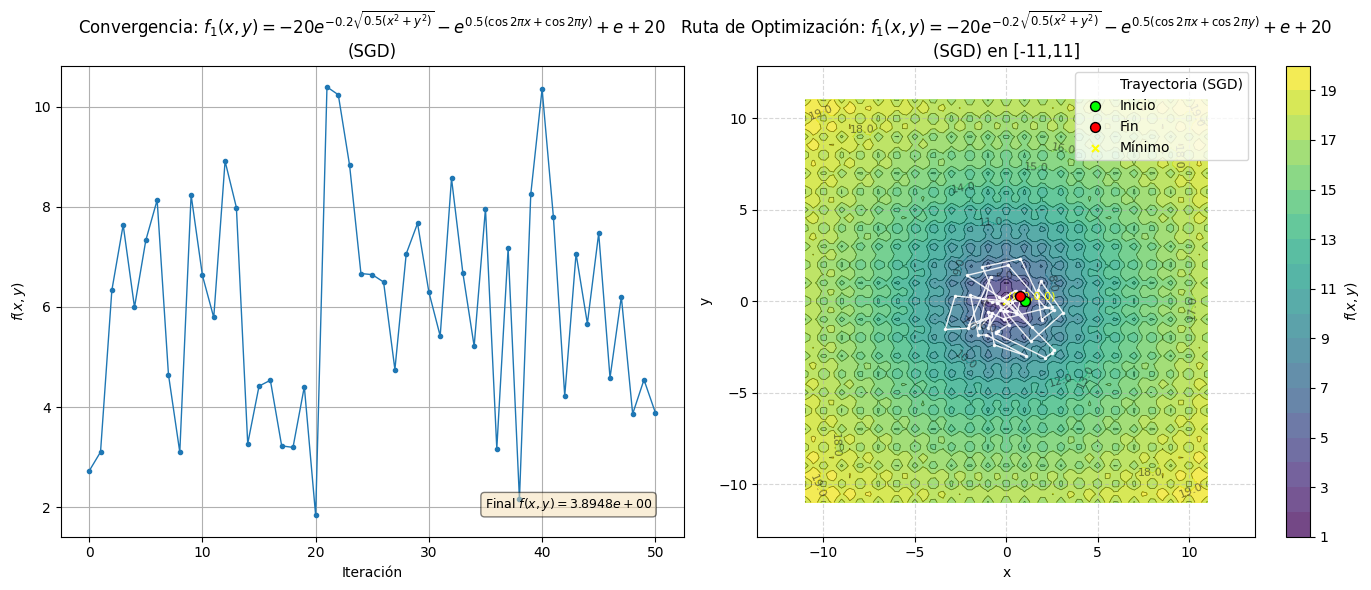

In [70]:
plot_the_best('SGD', 'f1', 1, test_run_history, plot_range=(-11, 11))

#### El mejor RMSProp, $f_2$

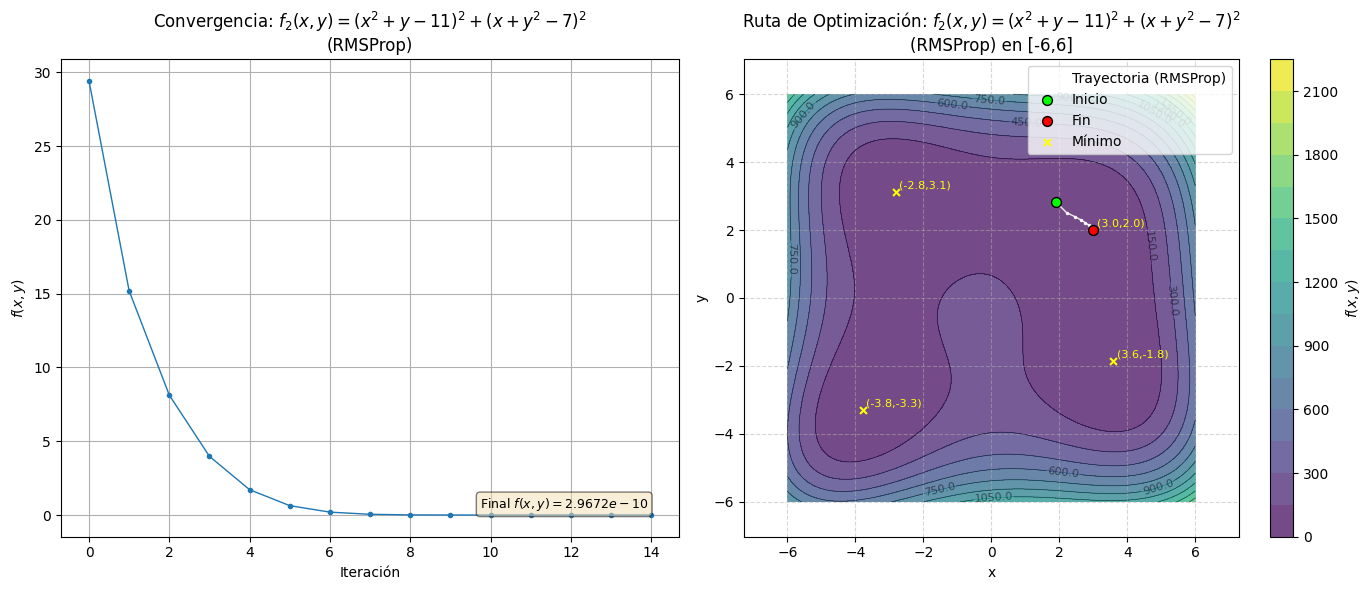

In [71]:
plot_the_best('RMSProp', 'f2', 2, test_run_history, plot_range=(-6, 6), mark_points=[(3, 2), (-2.805, 3.131), (-3.779, -3.283), (3.584, -1.848)])

#### El mejor SGD, $f_2$

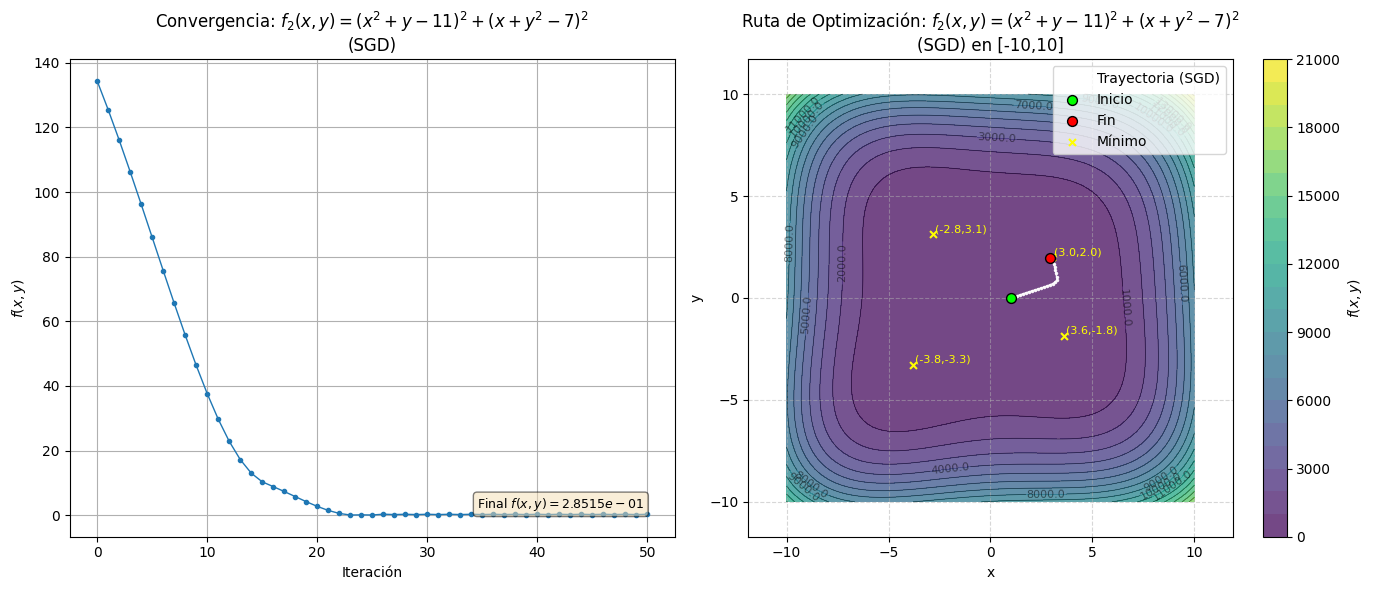

In [72]:
plot_the_best('SGD', 'f2', 2, test_run_history, plot_range=(-10, 10), mark_points=[(3, 2), (-2.805, 3.131), (-3.779, -3.283), (3.584, -1.848)])


---

### f) Realice una comparativa entre el algoritmo del descenso del gradiente y el algoritmo RMS prop. según los resultados obtenidos.

In [73]:
# Calculate the number of True values in the 'convergence_history' list for each row
test_run_history['converged times'] = test_run_history['convergence_history'].apply(lambda x: x.count(True))

# Select the desired columns to create the new table
test_results_table = test_run_history[['optimizer', 'function', 'converged times','best_run_number_of_iterations', 'average_fx', 'average_iterations']]

# Display the new table
test_results_table

optimizer function  converged times  best_run_number_of_iterations  \
0   RMSProp       f0                4                             13   
1       SGD       f0               10                              4   
2   RMSProp       f1                0                             50   
3       SGD       f1                0                             50   
4   RMSProp       f2                3                             14   
5       SGD       f2                0                             50   

     average_fx  average_iterations  
0  6.209696e-02                37.9  
1  1.912694e-10                 4.9  
2  7.666106e+00                50.0  
3  6.582207e+00                50.0  
4  3.542767e+00                43.4  
5  3.130984e-01                50.0



*   RMSProp fue capaz de converger casi todos los casos, pero este depende mucho de los puntos aleatoreos de inicio en realidad. Hemos notado como en muchas pruebas, con solo 50 iteraciones no es capaz de llegar al mínimo en $f_1$, aunque llega cerca del punto mínimo.
*   Descenso de Gradiente es altamente efectivo en el caso de $f_0$, que es una función convexa, y es capaz de encontrar el mínimo en menos iteraciones que el RMSProp.
*   En el caso de $f_1$, el Descenso de gradiente se atasca muy fácilmente en los mínimos locales de esta función, mientras el RMSProp muestra mayor robustez para salir de estos mínimos y poder explorar otras areas, sin embargo RMSProp no siempre es capaz de encontrar el mínimo local.
*   En el caso de $f_2$, ambos algoritmos suelen converger en alguno de los 4 mínimos globales, sin embargo, RMSProp puede en promedio converger en menos iteraciones que descenso de gradiente.



## 3.(30 puntos) Implemente el algoritmo de CMA-ES en Pytorch, de la forma más vectorial posible.


In [75]:
import torch.distributions.multivariate_normal as multivariate_normal

'''
Creates data with gaussian distribution
'''
def createDataOneClass(means, covarianceMatrix, numberSamples):
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    # Takes the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))

    return samples

createDataOneClass(torch.zeros(2), torch.eye(2), 10)

tensor([[ 1.3073,  0.8581],
        [ 2.5094,  2.2082],
        [ 0.1354, -0.3143],
        [ 0.7384, -0.6628],
        [ 0.9702, -0.2872],
        [ 1.5165, -0.7428],
        [ 2.0956, -1.3112],
        [ 1.6372, -1.2320],
        [ 1.7268,  0.2271],
        [ 0.9863, -0.3046]])

test_genera_poblacion_1: Passed!
test_genera_poblacion_2: Passed!
test_genera_poblacion_3: Passed!


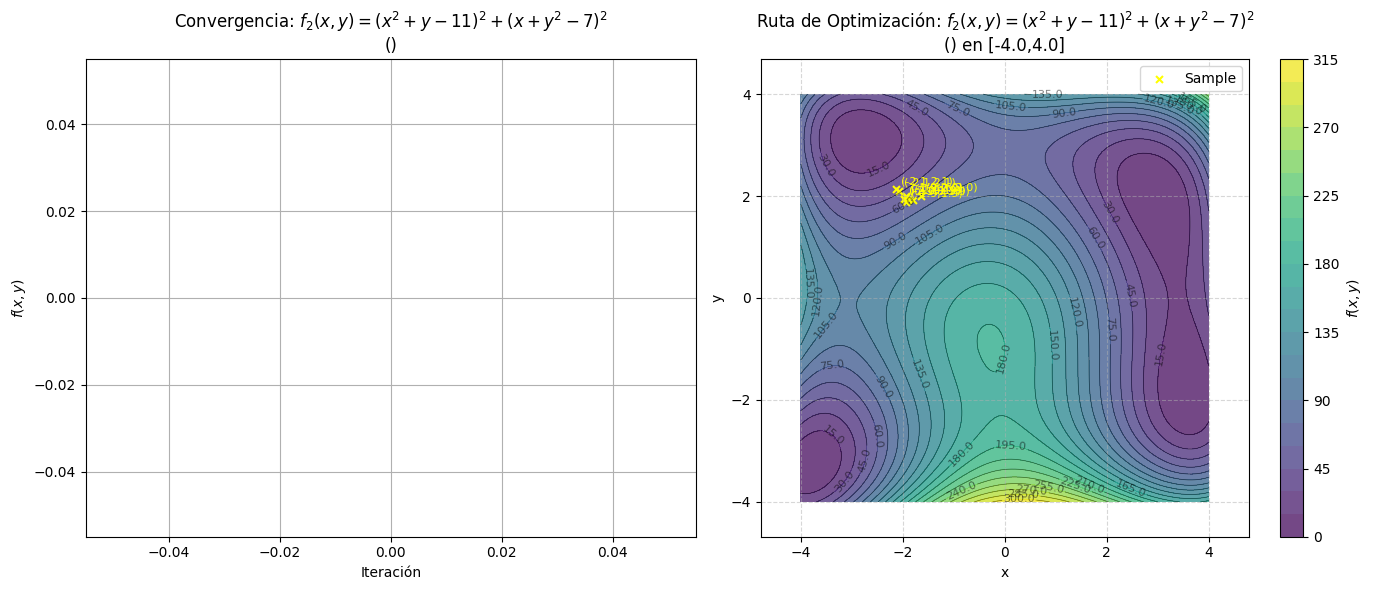

****
Other tests part of the CMA-ES algorithm

Population near (-2, 2):
 torch.Size([10, 2])
test fx(sample)
 tensor([42.6996, 39.7084, 56.1033, 51.6490, 53.3937, 53.4123, 52.8400, 59.6974,
        57.9442, 60.6802])
test weights formula
 tensor([0.1216, 0.1307, 0.0925, 0.1005, 0.0972, 0.0972, 0.0982, 0.0869, 0.0896,
        0.0855])
test f(mean) tensor([50.])
test covariance update,
 tensor([[0.0094, 0.0004],
        [0.0004, 0.0094]])


In [76]:
def genera_poblacion(numberSamples, dim=2, min_value=-10.0, max_value=10.0, means=None, covarianceMatrix=None):
  """!
  @brief: Genera una población alrededor de una media y una varianza, siguiendo una distribución Normal.

  @param n (int): Tamaño de la población.
  @param dim (int): Dimensión de los puntos en la población.
  @param min_value (float): Valor mínimo de los puntos en la población.
  @param max_value (float): Valor máximo de los puntos en la población.

  @return params_t (torch.Tensor): Población generada.
  @return mean (torch.Tensor): Media de la población.
  @return cov (torch.Tensor): Varianza de la población.
  """

  if means is None:
    means = torch.zeros(dim)
  if covarianceMatrix is None:
    covarianceMatrix = torch.eye(dim)

  # Inits the bi gaussian data generator
  multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
  # Takes the samples
  samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
  samples_clamped = torch.clamp(samples, min=min_value, max=max_value)
  return samples_clamped


def test_genera_poblacion_1():
  params_t = genera_poblacion(10)
  assert(params_t.shape == (10,2))
  print('test_genera_poblacion_1: Passed!')


def test_genera_poblacion_2():
  params_t = genera_poblacion(1)
  assert(params_t.shape == (1,2))
  print('test_genera_poblacion_2: Passed!')


def test_genera_poblacion_3():
  params_t = genera_poblacion(10, dim=1)
  assert(params_t.shape == (10,1))
  print('test_genera_poblacion_3: Passed!')

test_genera_poblacion_1()
test_genera_poblacion_2()
test_genera_poblacion_3()

m = torch.tensor((-2.0, 2.0), dtype=torch.float32)
C = 0.01*torch.eye(2)
sample = genera_poblacion(10, means=m, covarianceMatrix=C)

plot_optimization_results(
  funcs_pytorch_labels[2][0],
  [],
  [],
  funcs_pytorch_labels[2][2],
  "",
  (-4.0, 4.0),
  mark_points=sample.tolist(),
  points_label = 'Sample',
)

print("****\nOther tests part of the CMA-ES algorithm\n")

print("Population near (-2, 2):\n", sample.shape)

print("test fx(sample)\n", funcs_pytorch_labels[2][0](sample))

weights = (1/funcs_pytorch_labels[2][0](sample))/torch.sum(1/funcs_pytorch_labels[2][0](sample))
print("test weights formula\n", weights)

print("test f(mean)", funcs_pytorch_labels[2][0](m.unsqueeze(0)))

lr = 0.1

N = len(sample)

print("test covariance update,\n",
 (1.0 - lr) * C + lr * 1/N*torch.sum(weights*torch.matmul((sample - m), (sample - m).T)))

del(sample, lr, C, N, weights, m)


### Implementación de CMA-ES

(algoritmo visto en clase del 20 de mayo del 2025)

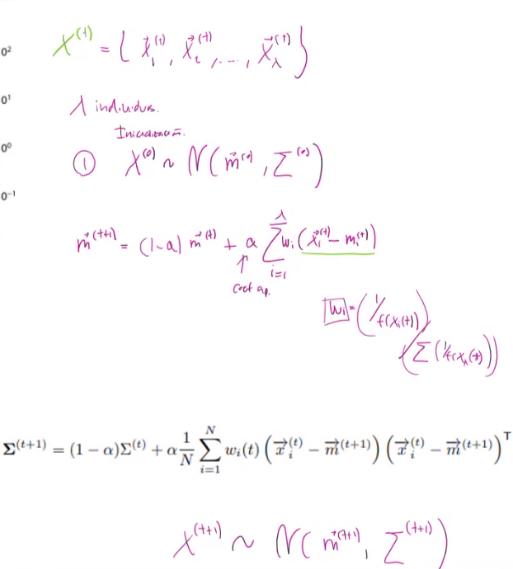

In [77]:
def cma_es(func_to_optimize, initial_params=(0., 0.), lr=0.01, population_size: int=10, epsilon = 1e-8,
           max_func_evaluations: int = 1000, history_params_x= [], history_fx = [], seed = None, verbose = False,
           debug = False):
  """!
  @brief: Implementa el algoritmo de CMA-ES en Pytorch.

  @param initial_params (torch.Tensor): Punto inicial.
  @param lr (float): tamaño del paso, coeficiente de aprendizaje.
  @param func_to_optimize (callable): Función a optimizar.
  @param population_size (int): Tamaño de la población.
  @param epsilon (float): Tolerancia de convergencia.
  @param max_func_evaluations (int): Cantidad máxima de evaluaciones de la función.
  @param seed (int): Opcional, semilla aleatoria para reproducibilidad.
  @param verbose (bool): Si se desean habilitar los mensajes intermedios para debugeo.
  @param debug (bool): Si se desean habilitar los mensajes intermedios para debugeo.

  @return fx (float): Valor de la función optimizada.
  """

  if seed is not None:
    torch.manual_seed(seed)

  N = population_size  # número de puntos muestreados
  m = torch.tensor(initial_params, dtype=torch.float32).unsqueeze(0)  # Vector media, shape = 1x2

  lr = torch.tensor(lr, dtype=torch.float32)  # Tamaño de paso
  C = torch.eye(len(m[0]), dtype=torch.float32)  # Matriz de covarianza (inicialmente identidad), shape 2x2

  history_params_x.append((tuple(m.squeeze().tolist())))
  history_fx.append(func_to_optimize(m).item())

  for i in range(max_func_evaluations):
    sample = genera_poblacion(N, means=m.squeeze(), covarianceMatrix=C)
    fx_sample = func_to_optimize(sample)

    # calcular persos para w_i
    weights = ((1/fx_sample)/torch.sum(1/fx_sample)).unsqueeze(1)

    if debug and (i + 1) % (max_func_evaluations // 10 if max_func_evaluations >= 10 else 1) == 0 or max_func_evaluations < 10:
      print('+'*100)
      print('m', m, m.shape)
      print('sample\n', sample, sample.shape)
      print('C\n', C, C.shape)
      print('weights\n', weights, weights.shape)
      print('fx_sample\n', fx_sample, fx_sample.shape)

    # actualiza media
    m = (1.0 - lr) * m + lr * torch.sum(weights * (sample - m))

    # actualiza la matriz de covarianza
    C = torch.abs((1.0 - lr) * C + lr * 1/N * torch.sum(weights * torch.matmul((sample - m), (sample - m).T)))  # C debe ser positiva

    # guarda nuevos valores de la media
    history_params_x.append((tuple(m.squeeze().tolist())))
    history_fx.append(func_to_optimize(m).item())

    if verbose and (i + 1) % (max_func_evaluations // 10 if max_func_evaluations >= 10 else 1) == 0 or max_func_evaluations < 10:
      print(f"Iter {i+1}/{max_func_evaluations}: f({history_params_x[-1]})\t=\t{history_fx[-1]}")
      if debug:
        print('-'*100)
        print('new m', m, m.shape)
        print('new C', C, C.shape)
        print('Nuevo fx', history_fx[-1])
        print('*'*100)

    if np.abs(history_fx[-2] - history_fx[-1]) < epsilon:
      if verbose:
        print(f"\n*** Iter {i+1}: CONVERGIO! en f({history_params_x[-1]})\t=\t{history_fx[-1]}...\n")
      break

  return history_fx[-1]

# Smoke test
history_params_test = []
# Smoke test
print("f(x,y):", cma_es(**{
  'func_to_optimize': funcs_pytorch_labels[2][0],
  'initial_params': [-3.0, 4.0],
  'lr': 0.21558420370190523,
  'population_size': 6,
  'max_func_evaluations': 500,
  'history_params_x': history_params_test,
  'history_fx': [],
  'seed': 1921,
  'verbose': True
}), "| (x,y):", history_params_test[-1], "| iteraciones:", len(history_params_test)-1)
del(history_params_test)

Iter 50/500: f((0.00040525131043978035, 0.0004426121013239026))	=	169.98458862304688
Iter 100/500: f((9.777225386642385e-06, 9.777424565982074e-06))	=	169.99964904785156

*** Iter 116: CONVERGIO! en f((9.839553172241722e-08, 9.839963865942991e-08))	=	170.0...

f(x,y): 170.0 | (x,y): (9.839553172241722e-08, 9.839963865942991e-08) | iteraciones: 116


#### Unit tests de CMA-ES

Iter 50/500: f((-0.023413194343447685, 0.012663185596466064))	=	0.0007085339748300612

*** Iter 95: CONVERGIO! en f((-0.00027282311930321157, 4.204979632049799e-05))	=	7.620064224056478e-08...



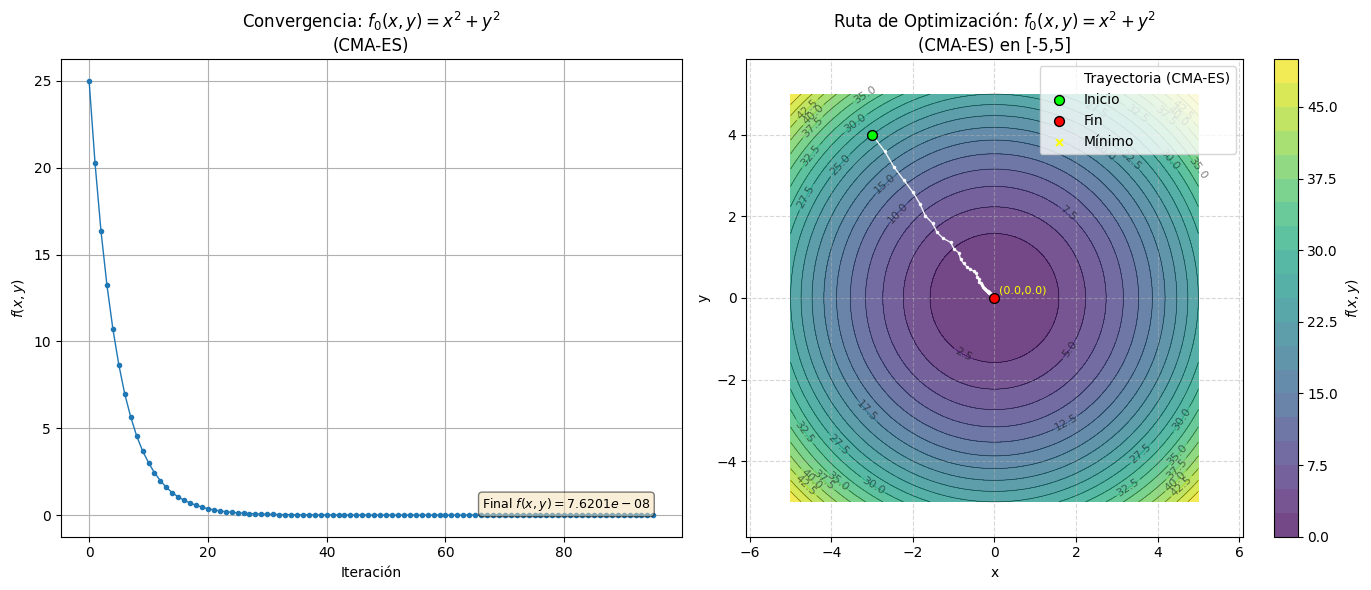


Last point (x, y):	(-0.000, 0.000)
Expected point (x, y):	(0.000, 0.000)

** test_1: FAILED!


In [78]:
P = 100
# Para f0, prueba desde (-3, 4), mínimo global: (0,0)
test_1_settings = {
  'optimizer_params': {
    'func_to_optimize': funcs_pytorch_labels[0][0],
    'initial_params': [-3.0, 4.0],
    'lr': 0.1,
    'population_size': 10,
    'max_func_evaluations': 500,
    'history_params_x': [],
    'history_fx': [],
    'verbose': True
  },
  'expected_x_y': [(0.0, 0.0)],
  'test_tolerance': 1e-8,
  'plot': {
    'func_name_str':funcs_pytorch_labels[0][2],
    'optimizer_name_str': "CMA-ES",
    'plot_range': (-5, 5),
    'mark_points': [(0, 0)],
    'points_label': 'Mínimo',
  }
}

test("test_1", optimizer=cma_es, **test_1_settings)

Iter 50/500: f((-0.017440304160118103, 0.018636083230376244))	=	0.08946609497070312
Iter 100/500: f((-0.0011708135716617107, -0.0009848843328654766))	=	0.004390716552734375
Iter 150/500: f((8.349416020791978e-05, 8.44523892737925e-05))	=	0.000335693359375

*** Iter 164: CONVERGIO! en f((-1.2838549082516693e-05, -1.2619339941011276e-05))	=	4.9591064453125e-05...



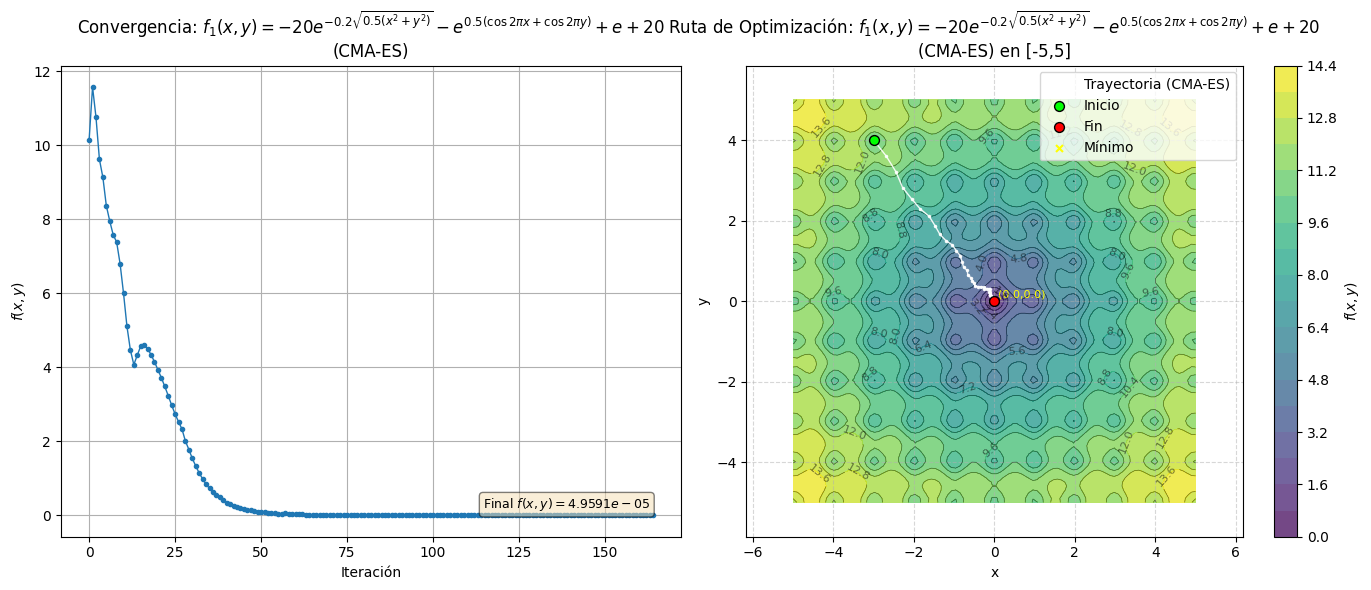


Last point (x, y):	(-0.000, -0.000)
Expected point (x, y):	(0.000, 0.000)

** test_2: FAILED!


In [79]:
P = 100
# Para f0, prueba desde (-3, 4), mínimo global: (0,0)
test_2_settings = {
  'optimizer_params': {
    'func_to_optimize': funcs_pytorch_labels[1][0],
    'initial_params': [-3.0, 4.0],
    'lr': 0.1,
     'population_size': 10,
    'max_func_evaluations': 500,
    'history_params_x': [],
    'history_fx': [],
    'verbose': True
  },
  'expected_x_y': [(0.0, 0.0)],
  'test_tolerance': 1e-8,
  'plot': {
    'func_name_str':funcs_pytorch_labels[1][2],
    'optimizer_name_str': "CMA-ES",
    'plot_range': (-5, 5),
    'mark_points': [(0, 0)],
    'points_label': 'Mínimo',
  }
}

test("test_2", optimizer=cma_es, **test_2_settings)

Iter 50/500: f((0.1895800083875656, -0.028485674411058426))	=	167.20681762695312
Iter 100/500: f((0.08988970518112183, 0.04233704134821892))	=	167.61822509765625
Iter 150/500: f((0.015964604914188385, 0.005594996735453606))	=	169.64764404296875
Iter 200/500: f((0.005462542176246643, 0.003201284445822239))	=	169.8523406982422
Iter 250/500: f((-0.0040725101716816425, -0.0045656124129891396))	=	170.15682983398438
Iter 300/500: f((-0.003782933345064521, -0.0038904622197151184))	=	170.13804626464844
Iter 350/500: f((-0.0021708314307034016, -0.002194279571995139))	=	170.07850646972656
Iter 400/500: f((0.0005697864107787609, 0.0005646732752211392))	=	169.97959899902344
Iter 450/500: f((0.0006038286373950541, 0.0006027136114425957))	=	169.97828674316406
Iter 500/500: f((3.9293830923270434e-05, 3.905064659193158e-05))	=	169.99859619140625


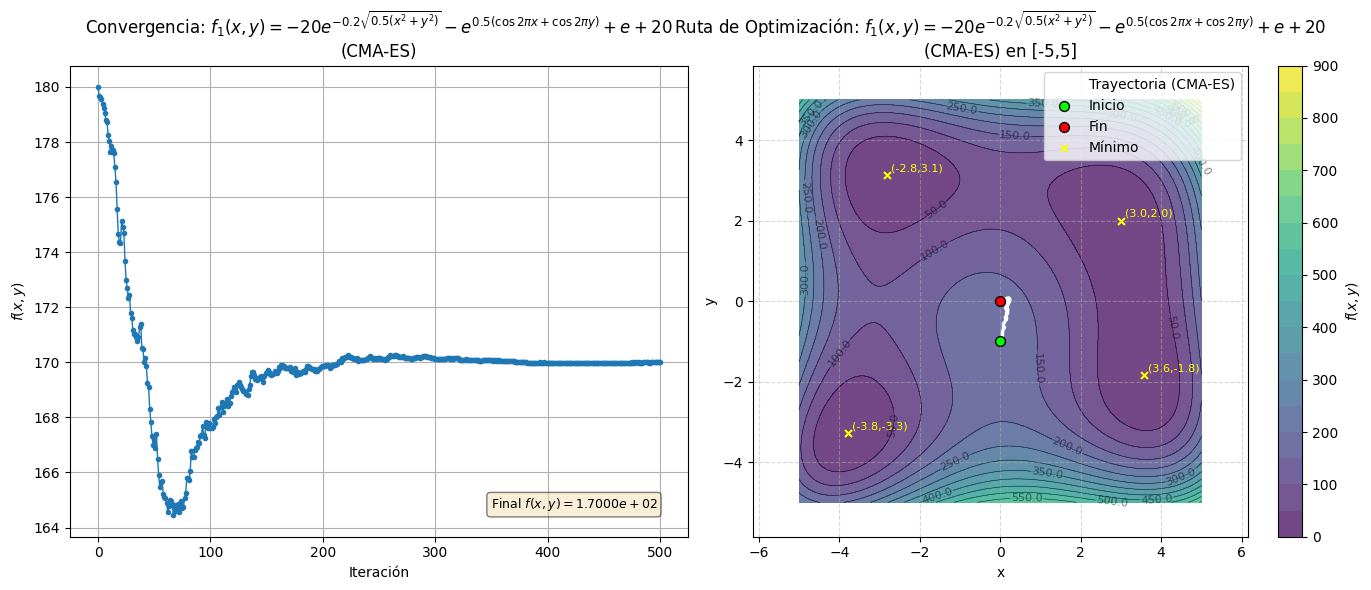


Last point (x, y):	(0.000, 0.000)
Expected point (x, y):	(3.000, 2.000)
Expected point (x, y):	(-2.805, 3.131)
Expected point (x, y):	(-3.779, -3.283)
Expected point (x, y):	(3.584, -1.848)

** test_3: FAILED!


In [80]:
# Para Himmelblau (f2), Prueba (-1,-1), Mínimos (3,2), (-2.805, 3.131), (-3.779, -3.283) y (3.584, -1.848)
test_3_settings = {
  'optimizer_params': {
    'func_to_optimize': funcs_pytorch_labels[2][0],
    'initial_params': [0.0, -1.0],
    'lr': 0.03,
     'population_size': 10,
    'max_func_evaluations': 500,
    'history_params_x': [],
    'history_fx': [],
    'verbose': True
  },
  'expected_x_y': [(3, 2), (-2.805, 3.131), (-3.779, -3.283), (3.584, -1.848)],
  'test_tolerance': 1e-1,
  'plot': {
     'func_name_str':funcs_pytorch_labels[1][2],
    'optimizer_name_str': "CMA-ES",
    'plot_range': (-5, 5),
    'mark_points': [(3, 2), (-2.805, 3.131), (-3.779, -3.283), (3.584, -1.848)],
    'points_label': 'Mínimo',
  }
}

test("test_3", optimizer=cma_es, **test_3_settings)

### a) Realice un proceso de calibración de sus hiper-parámetros usando optuna o weights and biases y reporte los mejores valores encontrados, usando como evidencia las gráficas de aprendizaje de los mejores hiper-parámetros encontrados.


##### Calibracion utilizando Optuna para CMA-ES

In [81]:
P = 500 # Cantidad de iteraciones
epsilon = 1e-8
min_lr = 1e-3
max_lr = 3e-1
min_pop = 20
max_pop = 100
n_trials = 100

def objective_cma_es_f0(trial):
  """!
  @brief Función objetivo para Optuna para calibrar CMA_ES.

  @param trial de Optuna, configura los hiperparámetros.
  @return Valor de la función objetivo, métrica a optimizar.
  """
  lr = trial.suggest_float('lr', min_lr, max_lr, log=True)
  pop_size = trial.suggest_int('population_size', min_pop, max_pop, log=True)  # lambda

  # Parámetros fijos
  iterations = P

  try:
    final_value = cma_es(**{
      'func_to_optimize': funcs_pytorch_labels[0][0],
      'initial_params': random_point().squeeze().tolist(),
      'lr': lr,
      'population_size': pop_size,
      'max_func_evaluations': iterations,
      'epsilon': epsilon,
      'history_params_x': [],
      'history_fx': [],
      'verbose': False
    })
  except Exception as e:
    raise optuna.TrialPruned()

  return final_value

def objective_cma_es_f1(trial):
  """!
  @brief Función objetivo para Optuna para calibrar CMA-ES.

  @param trial de Optuna, configura los hiperparámetros.
  @return Valor de la función objetivo, métrica a optimizar.
  """
  lr = trial.suggest_float('lr', min_lr, max_lr, log=True)
  pop_size = trial.suggest_int('population_size', min_pop, max_pop, log=True)  # lambda

  # Parámetros fijos
  iterations = P

  try:
    final_value = cma_es(**{
      'func_to_optimize': funcs_pytorch_labels[1][0],
      'initial_params': random_point().squeeze().tolist(),
      'lr': lr,
      'population_size': pop_size,
      'max_func_evaluations': iterations,
      'epsilon': epsilon,
      'history_params_x': [],
      'history_fx': [],
      'verbose': False,
    })
  except Exception as e:
    raise optuna.TrialPruned()

  return final_value


def objective_cma_es_f2(trial):
  """!
  @brief Función objetivo para Optuna para calibrar CMA_ES.

  @param trial de Optuna, configura los hiperparámetros.
  @return Valor de la función objetivo, métrica a optimizar.
  """
  lr = trial.suggest_float('lr', min_lr, max_lr, log=True)
  pop_size = trial.suggest_int('population_size', min_pop, max_pop, log=True)  # lambda

  # Parámetros fijos
  iterations = P

  try:
    final_value = cma_es(**{
      'func_to_optimize': funcs_pytorch_labels[2][0],
      'initial_params': random_point().squeeze().tolist(),
      'lr': lr,
      'population_size': pop_size,
      'max_func_evaluations': iterations,
      'epsilon': epsilon,
      'history_params_x': [],
      'history_fx': [],
      'verbose': False
    })
  except Exception as e:
    raise optuna.TrialPruned()
  return final_value


#### Estudio de Optuna

##### Calibracion de $f_0$

In [82]:
study_cma_es_f0 = perform_study(objective_cma_es_f0, "cma_es_f0_optimization", trials=n_trials)
cma_es_best_trial_f0 = study_cma_es_f0.best_trial

  0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
# Gráfica del historial de optimización: muestra cómo mejora el valor objetivo con cada trial.
fig_history = optuna.visualization.plot_optimization_history(study_cma_es_f0)
fig_history.show()

In [84]:
# # Gráfica de coordenadas paralelas: muestra cómo diferentes combinaciones de hiperparámetros afectan el resultado.
fig_parallel_coordinate = optuna.visualization.plot_parallel_coordinate(study_cma_es_f0)
fig_parallel_coordinate.show()



---


##### Calibracion de $f_1$

In [85]:
study_cma_es_f1 = perform_study(objective_cma_es_f1, "cma_es_f1_optimization", trials=n_trials)
cma_es_best_trial_f1 = study_cma_es_f1.best_trial

  0%|          | 0/100 [00:00<?, ?it/s]

In [86]:
# Gráfica del historial de optimización: muestra cómo mejora el valor objetivo con cada trial.
fig_history = optuna.visualization.plot_optimization_history(study_cma_es_f1)
fig_history.show()

In [87]:
# # Gráfica de coordenadas paralelas: muestra cómo diferentes combinaciones de hiperparámetros afectan el resultado.
fig_parallel_coordinate = optuna.visualization.plot_parallel_coordinate(study_cma_es_f1)
fig_parallel_coordinate.show()



---

##### Calibracion de $f_2$


In [88]:
study_cma_es_f2 = perform_study(objective_cma_es_f2, "cma_es_f2_optimization", trials=n_trials)
cma_es_best_trial_f2 = study_cma_es_f2.best_trial

  0%|          | 0/100 [00:00<?, ?it/s]

In [89]:
# Gráfica del historial de optimización: muestra cómo mejora el valor objetivo con cada trial.
fig_history = optuna.visualization.plot_optimization_history(study_cma_es_f2)
fig_history.show()

In [90]:
# # Gráfica de coordenadas paralelas: muestra cómo diferentes combinaciones de hiperparámetros afectan el resultado.
fig_parallel_coordinate = optuna.visualization.plot_parallel_coordinate(study_cma_es_f2)
fig_parallel_coordinate.show()

##### Valores obtenidos de la calibracion de CMA-ES

In [91]:
cma_es_optimization_best_values = []
for key, value in cma_es_best_trial_f0.params.items():
    cma_es_optimization_best_values.append(["f0", key, value])
for key, value in cma_es_best_trial_f1.params.items():
    cma_es_optimization_best_values.append(["f1", key, value])
for key, value in cma_es_best_trial_f2.params.items():
    cma_es_optimization_best_values.append(["f2", key, value])

cma_es_optimization_best_values = pd.DataFrame(cma_es_optimization_best_values,
                                               columns=["Funcion", "Hiperparametro", "mejor_valor"])
cma_es_optimization_best_values

Funcion   Hiperparametro  mejor_valor
0      f0               lr     0.233790
1      f0  population_size    30.000000
2      f1               lr     0.299682
3      f1  population_size    76.000000
4      f2               lr     0.001191
5      f2  population_size    36.000000

In [106]:
# Funcion 	Hiperparametro 	mejor_valor
# 0 	f0 	lr 	0.298115
# 1 	f0 	population_size 	37
# 2 	f1 	lr 	0.070769
# 3 	f1 	population_size 	22
# 4 	f2 	lr 	0.001002
# 5 	f2 	population_size 	100

if not _REGENERATE:
  # Reutiliza optimizacion de corrida anterior para reproducir resultados analizados
  data = {'Funcion': ['f0', 'f0', 'f1', 'f1', 'f2', 'f2'],
          'Hiperparametro': ['lr', 'population_size', 'lr', 'population_size', 'lr', 'population_size'],
          'mejor_valor': [0.298115, 37.000000, 0.070769, 22.000000, 0.001191, 36.000000]}
  cma_es_optimization_best_values = pd.DataFrame(data)

cma_es_optimization_best_values

Funcion   Hiperparametro  mejor_valor
0      f0               lr     0.298115
1      f0  population_size    37.000000
2      f1               lr     0.070769
3      f1  population_size    22.000000
4      f2               lr     0.001191
5      f2  population_size    36.000000

### b) Para los mejores valores encontrados, en cada funcion, por un máximo de 50 iteraciones:

  1.   Ejecute el algoritmo 10 corridas diferentes, y documente en una tabla la cantidad de iteraciones para converger a el o los puntos minimos (indique si convergió). **Los 10 puntos iniciales escogidos deben preservarse para todos los algoritmos a probar** (deben distribuirse de forma cercana a los del descenso del **gradiente y el RMS prop**).
  2. Muestre el valor promedio de la función minimizada para las 10 corridas, y la cantidad de iteraciones promedio en converger.


In [107]:
run_history_cma_es = []

# Valores fijos
P = 500
test_tolerance = 1e-8
epsilon= 1e-8


def evaluate_optimizer_v2(func_name, func_to_optimize, derivative_func, optimizer_name, optimizer, function_minimums=[],
                       test_points=[], test_tolerance=test_tolerance, epsilon=epsilon, epochs=P, lr=0.01, gamma=0.99,
                       population_size = 10, seed=None, clip_gradient=False, verbose=False, debug=False):
  """!
      @brief: Ejecutor de pruebas, realiza una corrida para cada punto en test_points, y devuelve un DataFrame con los resultados.

      @param func_name (str): Nombre de la función.
      @param func_to_optimize (callable): Función a optimizar.
      @param derivative_func (callable): Derivada de la función a optimizar.
      @param optimizer_name (str): Nombre del optimizador, valores aceptados: RMSProp, SGD.
      @param optimizer (callable): Función del optimizador.
      @param function_minimums (list): Lista de tensores, cada tensor es un mínimos de la función a optimizar.
      @param test_points (list): Lista de puntos a evaluar.
      @param test_tolerance (float): Tolerancia para evaluar si hubo convergencia.
      @param epsilon (float): Tolerancia para la convergencia.
      @param epochs (int): Cantidad de iteraciones del optimizador.
      @param lr (float): Tasa de aprendizaje.
      @param gamma (float): Factor de decaimiento.
      @param population_size (int): Tamaño de la población.
      @param seed (int): Opcional, semilla aleatoria para reproducibilidad.
      @param clip_gradient (bool): Si se desea aplicar gradient clipping.
      @param verbose (bool): Si se desean habilitar los mensajes intermedios para debugeo.
      @param debug (bool): Si se desean habilitar mensajes intermedios adicionales para debugeo.

      @return Diccionario con los resultados.
  """

  hist_iterations = []
  hist_converged = []
  hist_fx = []

  best_run_history_params_x: List[Tuple[float, float]] = []
  best_run_history_values: List[float] = []
  best_run_iterations = float('inf')
  the_best_converged = False

  test_run = 0
  for point in test_points:
    initial_point = point.clone()
    test_run += 1

    if verbose:
      print(f"\nCorrida {test_run}, {func_name}({point})")

    history_params_x = []
    history_fx= []
    fx = float('inf')
    if optimizer_name == 'RMSProp':
      fx = optimizer(**{
        'func_to_optimize': func_to_optimize,
        'derivative_func': derivative_func,
        'initial_params': initial_point,
        'learning_rate': lr,
        'N': epochs,
        'gamma': gamma,
        'epsilon': epsilon,
        'history_params_x': history_params_x,
        'history_fx': history_fx,
        'verbose': verbose,
      })
    elif optimizer_name == 'SGD':
      fx = optimizer(**{
        'func_to_optimize': func_to_optimize,
        'derivative_func': derivative_func,
        'initial_params': initial_point,
        'learning_rate': lr,
        'N': epochs,
        'epsilon': epsilon,
        'history_params_x': history_params_x,
        'history_fx': history_fx,
        'verbose': verbose,
        'clip_gradient': clip_gradient,
      })
    else:
      fx = cma_es(**{
      'func_to_optimize': func_to_optimize,
      'initial_params': initial_point.squeeze().tolist(),
      'lr': lr,
      'population_size': population_size,
      'max_func_evaluations': epochs,
      'epsilon': epsilon,
      'history_params_x': history_params_x,
      'history_fx': history_fx,
      'seed': seed,
      'verbose': verbose,
      'debug': debug,
    })

    iterations = len(history_params_x)-1 # history_params_x[0] es el punto inicial.
    converged = any([abs(fx - minimo) <= test_tolerance for minimo in function_minimums])
    hist_iterations.append(iterations)
    hist_converged.append(converged)
    hist_fx.append(fx)

    # Prueba si esta corrida es mejor que la mejor registrada
    if (iterations < best_run_iterations) and ((the_best_converged and converged) or (not the_best_converged)):
      best_run_iterations = iterations
      best_run_history_params_x = history_params_x
      best_run_history_values = history_fx
      the_best_converged = converged


  runs_df = pd.DataFrame({
      'Iteraciones': hist_iterations,
      'f(x)': hist_fx,
      'Convergio': hist_converged,
  })
  print(tabulate(runs_df, headers='keys', tablefmt='psql'))

  return RunHistory(
      optimizer_name,
      func_name,
      hist_iterations,
      hist_converged,
      runs_df['f(x)'].mean(),
      runs_df['Iteraciones'].mean(),
      best_run_iterations,
      best_run_history_params_x,
      best_run_history_values,
  )

#### CMA-ES, $f_0$ (10 corridas, mejores hiperparámetros)

In [108]:
_f_name = 'f0'
cma_es_optimization_best_values[cma_es_optimization_best_values["Funcion"] == _f_name]

Funcion   Hiperparametro  mejor_valor
0      f0               lr     0.298115
1      f0  population_size    37.000000

In [109]:
import random

seed = 17056420634
if _REGENERATE:
  seed = random.randint(0, 99999999999)

run_history_cma_es.append(evaluate_optimizer_v2(**{
  'func_name': _f_name,
  'func_to_optimize': funcs_pytorch_labels[0][0],
  'derivative_func': None,
  'optimizer_name': 'CMA-ES',
  'optimizer': cma_es,
  'function_minimums': [0.0],
  'lr': cma_es_optimization_best_values[cma_es_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[0],
  'population_size': int(cma_es_optimization_best_values[cma_es_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[1]),
  'seed': seed,
  'test_points': test_points,
  'verbose': False,
  'debug': False,
}))
print('seed', seed)
print('total de pruebas registradas', len(run_history_cma_es))


+----+---------------+-------------+-------------+
|    |   Iteraciones |        f(x) | Convergio   |
|----+---------------+-------------+-------------|
|  0 |            29 | 2.91162e-09 | True        |
|  1 |            38 | 2.46726e-10 | True        |
|  2 |            38 | 1.34621e-10 | True        |
|  3 |            38 | 2.28276e-10 | True        |
|  4 |            38 | 8.1857e-11  | True        |
|  5 |            33 | 1.35554e-08 | False       |
|  6 |            31 | 6.28638e-08 | False       |
|  7 |            38 | 1.94659e-10 | True        |
|  8 |            38 | 1.54851e-10 | True        |
|  9 |            38 | 6.86496e-11 | True        |
+----+---------------+-------------+-------------+
seed 17056420634
total de pruebas registradas 1




---



#### CMA-ES, $f_1$ (10 corridas, mejores hiperparámetros)


In [110]:
_f_name = 'f1'
cma_es_optimization_best_values[cma_es_optimization_best_values["Funcion"] == _f_name]

Funcion   Hiperparametro  mejor_valor
2      f1               lr     0.070769
3      f1  population_size    22.000000

In [111]:
import random

seed = 14998272320
if _REGENERATE:
  seed = random.randint(0, 99999999999)

run_history_cma_es.append(evaluate_optimizer_v2(**{
  'func_name': _f_name,
  'func_to_optimize': funcs_pytorch_labels[1][0],
  'derivative_func': None,
  'optimizer_name': 'CMA-ES',
  'optimizer': cma_es,
  'function_minimums': [0.0],
  'lr': cma_es_optimization_best_values[cma_es_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[0],
  'population_size': int(cma_es_optimization_best_values[cma_es_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[1]),
  'seed': seed,
  'test_points': test_points,
  'verbose': False,
  'debug': False,
}))
print('seed', seed)
print('total de pruebas registradas', len(run_history_cma_es))


+----+---------------+-------------+-------------+
|    |   Iteraciones |        f(x) | Convergio   |
|----+---------------+-------------+-------------|
|  0 |           192 | 0           | True        |
|  1 |           192 | 1.52588e-05 | False       |
|  2 |           192 | 7.62939e-06 | False       |
|  3 |           192 | 1.52588e-05 | False       |
|  4 |           192 | 1.14441e-05 | False       |
|  5 |           192 | 0           | True        |
|  6 |           206 | 5.34058e-05 | False       |
|  7 |           192 | 1.90735e-05 | False       |
|  8 |           151 | 0.000404358 | False       |
|  9 |           192 | 1.14441e-05 | False       |
+----+---------------+-------------+-------------+
seed 14998272320
total de pruebas registradas 2




---



#### CMA-ES, $f_2$ (10 corridas, mejores hiperparámetros)


In [112]:
_f_name = 'f2'
cma_es_optimization_best_values[cma_es_optimization_best_values["Funcion"] == _f_name]

Funcion   Hiperparametro  mejor_valor
4      f2               lr     0.001191
5      f2  population_size    36.000000

In [113]:
import time


# seed = 17056420634
# if not _REGENERATE:
seed = random.randint(0, 99999999999999999)

run_history_cma_es.append(evaluate_optimizer_v2(**{
  'func_name': _f_name,
  'func_to_optimize': funcs_pytorch_labels[2][0],
  'derivative_func': None,
  'optimizer_name': 'CMA-ES',
  'optimizer': cma_es,
  'function_minimums': [0.0],
  'lr': cma_es_optimization_best_values[cma_es_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[0],
  'population_size': int(cma_es_optimization_best_values[cma_es_optimization_best_values["Funcion"] == _f_name]['mejor_valor'].iloc[1]),
  'seed': seed,
  'test_points': test_points,
  'verbose': False,
  'debug': False,
}))
print('seed', seed)
print('total de pruebas registradas', len(run_history_cma_es))

+----+---------------+----------+-------------+
|    |   Iteraciones |     f(x) | Convergio   |
|----+---------------+----------+-------------|
|  0 |           500 | 132.257  | False       |
|  1 |           500 |  46.2099 | False       |
|  2 |           500 | 131.323  | False       |
|  3 |           500 | 195.365  | False       |
|  4 |           500 |  26.2189 | False       |
|  5 |           500 |  59.8014 | False       |
|  6 |           500 |  26.1617 | False       |
|  7 |           500 | 390.574  | False       |
|  8 |           500 |  24.7657 | False       |
|  9 |           500 | 594.742  | False       |
+----+---------------+----------+-------------+
seed 52916585216088643
total de pruebas registradas 3


In [114]:
test_run_history_cma_es = pd.DataFrame([asdict(run_history) for run_history in run_history_cma_es])
test_run_history_cma_es

optimizer function                                 iterations_history  \
0    CMA-ES       f0           [29, 38, 38, 38, 38, 33, 31, 38, 38, 38]   
1    CMA-ES       f1  [192, 192, 192, 192, 192, 192, 206, 192, 151, ...   
2    CMA-ES       f2  [500, 500, 500, 500, 500, 500, 500, 500, 500, ...   

                                 convergence_history    average_fx  \
0  [True, True, True, True, True, False, False, T...  8.044048e-09   
1  [True, False, False, False, False, True, False...  5.378723e-05   
2  [False, False, False, False, False, False, Fal...  1.627419e+02   

   average_iterations  best_run_number_of_iterations  \
0                35.9                             29   
1               189.3                            192   
2               500.0                            500   

                              best_run_history_route  \
0  [(1.028499960899353, 0.004699999932199717), (0...   
1  [(1.028499960899353, 0.004699999932199717), (0...   
2  [(1.028499960899353, 0.004699999932199717), (1...   

                             best_run_history_values  
0  [1.057834267616272, 0.2905203700065613, 0.1339...  
1  [2.7296295166015625, 2.5811691284179688, 2.711...  
2  [134.41221618652344, 134.41688537597656, 134.4...


### c) Muestre los puntos visitados del algoritmo para la mejor corrida (convergencia mas rapida) para cada función. Para ello use el gráfico de las curvas de nivel. Además para tales corridas, grafique la curva de aprendizaje.


##### El mejor CMA-ES para $f_0$

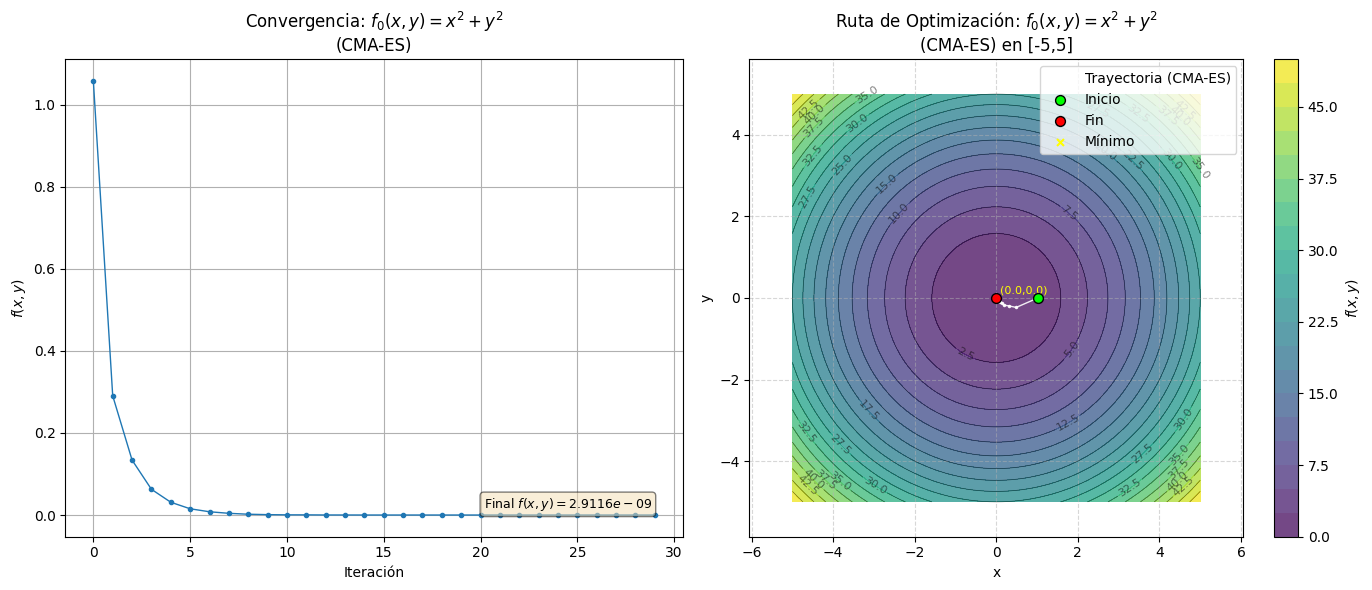

In [115]:
plot_the_best('CMA-ES', 'f0', 0, test_run_history_cma_es)

##### El mejor CMA-ES para $f_1$

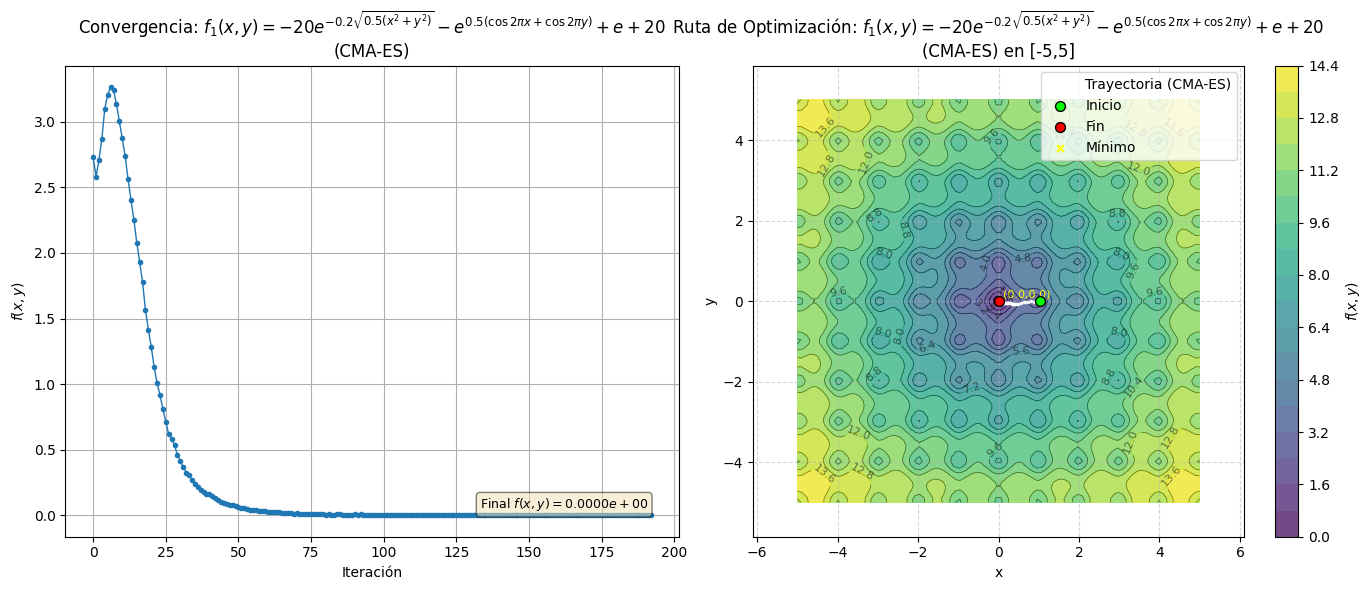

In [116]:
plot_the_best('CMA-ES', 'f1', 1, test_run_history_cma_es)

##### El mejor CMA-ES para $f_2$

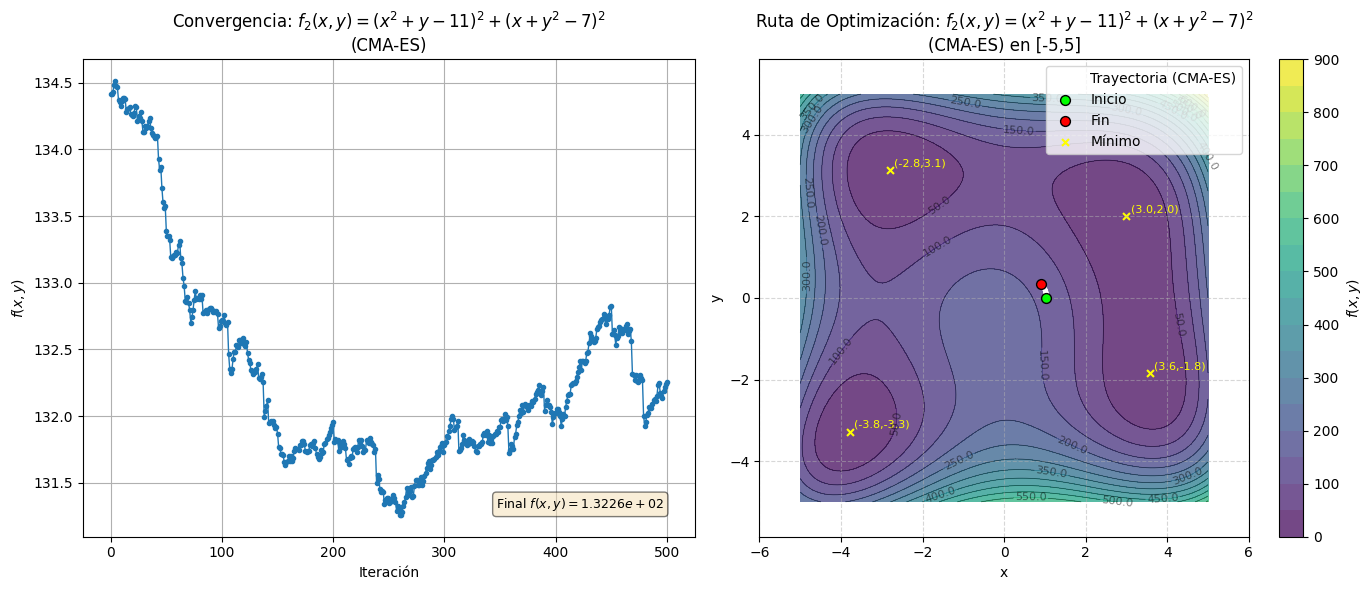

In [117]:
plot_the_best('CMA-ES', 'f2', 2, test_run_history_cma_es, mark_points=[(3, 2), (-2.805, 3.131), (-3.779, -3.283), (3.584, -1.848)])



---



In [118]:
# Calculate the number of True values in the 'convergence_history' list for each row
test_run_history_cma_es['converged times'] = test_run_history_cma_es['convergence_history'].apply(lambda x: x.count(True))

# Select the desired columns to create the new table
test_results_cma_es_table = test_run_history_cma_es[['optimizer', 'function', 'converged times','best_run_number_of_iterations', 'average_fx', 'average_iterations']]

# Display the new table
test_results_cma_es_table

optimizer function  converged times  best_run_number_of_iterations  \
0    CMA-ES       f0                8                             29   
1    CMA-ES       f1                2                            192   
2    CMA-ES       f2                0                            500   

     average_fx  average_iterations  
0  8.044048e-09                35.9  
1  5.378723e-05               189.3  
2  1.627419e+02               500.0

### d) ¿Cómo podría mezclar el algoritmo del descenso del gradiente con el algoritmo de CMA-ES? ¿Qué beneficios tendría el hacerlo? ¿Hay trabajo anterior en la literatura al respecto (use referencias)?

1. La mezcla de SGD y CMA-ES puede realizarse de diversas formas, por ejemplo, los enfoques secuenciales son los más comunes, donde CMA-ES se utiliza para una exploración global inicial para identificar regiones prometedoras, y SGD luego refina la solución localmente dentro de esas regiones[1]. Otra estrategia es la alternancia iterativa, donde los algoritmos se ejecutan cíclicamente. A un nivel más integrado, la información del gradiente (si está disponible) puede usarse para modificar directamente los parámetros de CMA-ES, como su media de búsqueda, para guiarla hacia descensos más rápidos[2].

  Los algoritmos meméticos representan otra vía, donde SGD o CMA-ES actúan como un optimizador local dentro de un marco evolutivo global más amplio, refinando las soluciones encontradas por el algoritmo evolutivo principal[3].
  
  Finalmente, existen híbridos específicos como Adam-CMA-ES, que buscan combinar la rápida convergencia de variantes de SGD como Adam con la robustez de CMA-ES[4], y enfoques más avanzados como Stein Variational CMA-ES (SV-CMA-ES) que fusionan conceptos de inferencia variacional basada en gradientes con CMA-ES[5].

2. La hibridación de SGD y CMA-ES ofrece múltiples beneficios significativos. Principalmente, conduce a una mejora en la calidad de la solución y la eficiencia de convergencia, ya que se combinan la exploración global de CMA-ES con la explotación local eficiente de SGD[2]. Esto permite superar mesetas y óptimos locales de baja calidad donde SGD podría estancarse. Se logra un incremento en la robustez y la capacidad de exploración global, permitiendo manejar paisajes de optimización complejos, no convexos, multimodales o con gradientes ruidosos / o en cero de manera más efectiva que SGD por sí solo[1]. La combinación facilita un mejor equilibrio entre exploración y explotación, adaptándose a las diferentes fases de la búsqueda[5]. Además, en el contexto del aprendizaje automático, existe el potencial de encontrar mínimos más planos en el paisaje de pérdida, lo que podría conducir a una mejor generalización de los modelos[6].

3. Sí, existe una extensa base de trabajos anteriores en la literatura científica sobre la hibridación de GD y CMA-ES. La idea no es reciente y se apoya en fundamentos teóricos que conectan ambos enfoques, como la relación de CMA-ES con el descenso de gradiente vainilla.
  Contribuciones clave incluyen el trabajo de Chen, Liu, y Jia (2009)[3], quienes propusieron un híbrido donde la información del gradiente ajusta la media de CMA-ES, demostrando mejoras en eficiencia y efectividad para el aprendizaje discriminativo de clasificadores Bayesianos. Loshchilov y Hutter[7] han explorado combinaciones de Adam (una variante de SGD) con CMA-ES, especialmente para la optimización de hiperparámetros de redes neuronales profundas y en propuestas de métodos híbridos más directos.
  
  Otros enfoques relevantes incluyen LS-CMA-ES, que incorpora información de segundo orden (aproximaciones de la Hessiana) dentro de CMA-ES, y algoritmos meméticos como MA-LS-Chain[4] que utilizan CMA-ES como un potente optimizador local. Aplicaciones específicas de híbridos SGD-CMA-ES se han visto en el entrenamiento de Physics-Informed Neural Networks (PINNs)[8], aprendizaje cuántico variacional[1], y en problemas de ingeniería como la optimización del control de pozos petroleros[2]. Estos trabajos validan consistentemente las ventajas de combinar estos algoritmos de optimización.

Referencias:

  *     [1] Anantharamakrishnan, V., & Taddei, M. M. (2024). Quantum Time-Series Learning with Evolutionary Algorithms. arXiv preprint arXiv:2412.17580.
  *     [2] Kumar, A. (2021). Hybrid evolutionary optimization approach for oilfield well control optimization. arXiv preprint arXiv:2103.15608.
  *     [3] Chen, X., Liu, X., & Jia, Y. (2009, July). Combining evolution strategy and gradient descent method for discriminative learning of bayesian classifiers. In Proceedings of the 11th Annual conference on Genetic and evolutionary computation (pp. 507-514).
  *     [4] Molina, D., Lozano, M., & Herrera, F. (2009, July). A memetic algorithm using local search chaining for black-box optimization benchmarking 2009 for noisy functions. In Proceedings of the 11th Annual Conference Companion on Genetic and Evolutionary Computation Conference: Late Breaking Papers (pp. 2359-2366).
  *     [5] Kumari, A., Kumari M., Kumari B. (2024, July). Optimization In Machine Learning: Gradient Descent vs Evolutionary Strategies. International Journal of Innovative Research in Computer and Communication Engineering, Volume 12, Issue 7.
  *     [6] Nomura, M., & Shibata, M. (2024). cmaes: A simple yet practical python library for cma-es. arXiv preprint arXiv:2402.01373.
  *     [7] Loshchilov, I., & Hutter, F. (2016). CMA-ES for hyperparameter optimization of deep neural networks. arXiv preprint arXiv:1604.07269.
  *     [8] El Hachimi, C., Belaqziz, S., Khabba, S., Daccache, A., Ait Hssaine, B., Karjoun, H., ... & Chehbouni, A. (2025). Physics-informed neural networks for enhanced reference evapotranspiration estimation in Morocco: Balancing semi-physical models and deep learning. Chemosphere, 374, 144238.


## 4.(10 puntos) Compare los resultados de todos los algoritmos probados, y argumente las ventajas y desventajas de cada uno, usando fuentes externas debidamente citadas.

Ver reporte escrito.



### Tabla de Resultados finales

In [119]:
test_results_combined_table = pd.concat([test_results_table, test_results_cma_es_table], ignore_index=True)
test_results_combined_table

optimizer function  converged times  best_run_number_of_iterations  \
0   RMSProp       f0                4                             13   
1       SGD       f0               10                              4   
2   RMSProp       f1                0                             50   
3       SGD       f1                0                             50   
4   RMSProp       f2                3                             14   
5       SGD       f2                0                             50   
6    CMA-ES       f0                8                             29   
7    CMA-ES       f1                2                            192   
8    CMA-ES       f2                0                            500   

     average_fx  average_iterations  
0  6.209696e-02                37.9  
1  1.912694e-10                 4.9  
2  7.666106e+00                50.0  
3  6.582207e+00                50.0  
4  3.542767e+00                43.4  
5  3.130984e-01                50.0  
6  8.044048e-09                35.9  
7  5.378723e-05               189.3  
8  1.627419e+02               500.0